<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Generate-jet-images" data-toc-modified-id="Generate-jet-images-1">Generate jet images</a></span><ul class="toc-item"><li><span><a href="#plot-some-jets" data-toc-modified-id="plot-some-jets-1.1">plot some jets</a></span></li></ul></li><li><span><a href="#Training-neural-networks" data-toc-modified-id="Training-neural-networks-2">Training neural networks</a></span><ul class="toc-item"><li><span><a href="#run-on-Colab" data-toc-modified-id="run-on-Colab-2.1">run on Colab</a></span></li><li><span><a href="#analyze" data-toc-modified-id="analyze-2.2">analyze</a></span><ul class="toc-item"><li><span><a href="#Check-effect-of-pixel-normalization" data-toc-modified-id="Check-effect-of-pixel-normalization-2.2.1">Check effect of pixel normalization</a></span></li><li><span><a href="#Compare-to-high-pT-jets" data-toc-modified-id="Compare-to-high-pT-jets-2.2.2">Compare to high pT jets</a></span></li></ul></li></ul></li></ul></div>

See details and walkthrough for this notebook at https://ilmonteux.github.io/2018/10/15/jet-tagging-cnn.html

## Load libraries and functions

In [74]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[]


In [2]:
import sys, os
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
from tabulate import tabulate
import seaborn as sns
import h5py
import awkward as ak
import math
from scipy import stats


# find pythia path so you can import it
pythia_path = '/Users/mghasemi/Desktop/Code/Code/Generators/pythia8310/'
cfg = open(pythia_path+"examples/Makefile.inc")
lib = pythia_path+"lib"
for line in cfg:
    if line.startswith("PREFIX_LIB="): lib = line[11:-1]; break
sys.path.insert(0, lib)
import pythia8

# define general variables
etaedges = np.arange(-3,3+0.01,0.12)
phiedges = np.arange(-np.pi*4/3,np.pi*4/3+0.01,np.pi/18.)
cmap = plt.get_cmap('gray_r')
PTCUT = 50.
nevents = 5000
outdir = 'images_out/'

"""
Write two Madgraph cards for production of up and anit-up events.
Apply generator-level cut on the particle momenta given by PTRANGE,
allowing for a tolerance delta. If argument extra is specified, 
append it to output directories
"""
def write_mg_cards(PTRANGE, delta=10, nevents=200000, extra=''):
    with open('generate_up.mg5','w') as f:
        f.write("""
    generate p p > u g
    output jets_up{3}
    launch
    madspin=none
    done
    set nevents {2}
    set pt_min_pdg {{ 2: {0} }}
    set pt_max_pdg {{ 2: {1} }}
                done    
    """.format(PTRANGE[0]-delta, PTRANGE[1]+delta, nevents, extra))

    with open('generate_upbar.mg5','w') as f:
        f.write("""
    generate p p > u~ g
    output jets_qcd{3}
    launch
    done
    set nevents {2}
    set ptj {0}
    set ptjmax {1}
    done    
    """.format(PTRANGE[0]-delta, PTRANGE[1]+delta, nevents, extra))


"""
If a jet center is close to either 0 or 2*pi, its constituents could be on the other side
of the periodicity line. This takes care of this problem by remapping phi to be either
above 2*pi or below zero.
"""
def extend_jet_phi(phi, jet_phi):
    if abs(jet_phi + np.pi)<1.: # phi close to -pi
        return phi-2*np.pi*int(abs(phi-np.pi) <1-abs(jet_phi + np.pi))
    elif abs(jet_phi - np.pi)<1.: # phi close to pi
        return phi+2*np.pi*int(abs(-phi-np.pi) < 1-abs(jet_phi - np.pi)) 
    else: 
        return phi


""" 
Leading jet and constituents are passed as pythia vec4 objects.
Restricts image grid to within a DeltaR=1.2 range around jet center.
Returns pT-weighted histogram, and tuple with histogram grid.
"""
def make_image_leading_jet(leading_jet, leading_jet_constituents, charge):
    jet_phi = leading_jet.phi()
    jet_eta = leading_jet.eta()
    ### redefine grid to only be Delta R=1.2 around jet center
    yedges = [phi for phi in phiedges if abs(phi-jet_phi)<=1.2+(phiedges[1]-phiedges[0])]
    xedges = [eta for eta in etaedges if abs(eta-jet_eta)<=1.2+(etaedges[1]-etaedges[0])]
    
    jet_constituents = np.array([ [c.pT(), c.eta(), extend_jet_phi(c.phi(), jet_phi) ] for c in leading_jet_constituents ])    
    jet_charge = np.array([[c] for c in charge])    
    jet_constituents = np.concatenate((jet_constituents, jet_charge), axis = 1)     
    

    #histo, xedges, yedges =  np.histogram2d(jet_constituents[:,1], jet_constituents[:,2], bins=(xedges,yedges), weights=jet_constituents[:,0])
    histo, xedges, yedges =  np.histogram2d(jet_constituents[:,1], jet_constituents[:,2], bins=(xedges,yedges), weights=jet_constituents[:,3])    
    #histo, xedges, yedges =  np.histogram2d(jet_constituents[:,1], jet_constituents[:,2], bins=(xedges,yedges), weights=jet_constituents[:,3], density=True)    
    #print('jet_constituents:\n', jet_constituents)    
    
    ### transpose to have eta=x, phi=y
    #print(histo.T.shape)

    return histo.T, (xedges, yedges)
    

""" 
Jets are passed as pythia vec4 objects
Returns list of pT-weighted histogram, and tuple with histogram grids, covering full (eta,phi) ranges
"""    
def make_image_event(all_jets, all_constituents, charge):    
    out=[]
    for i in range(len(all_jets)):
        jet_phi = all_jets[i].phi()
        
        jet_constituents = np.array([ [c.pT(), c.eta(), extend_jet_phi(c.phi(), jet_phi) ] for c in all_constituents[i] ])    
        jet_charge = np.array([[c] for c in charge[i]])        
        jet_constituents = np.concatenate((jet_constituents, jet_charge), axis=1)
        #print('jet_constituents:\n', jet_constituents)        

        #histo, xedges, yedges =  np.histogram2d(jet_constituents[:,1], jet_constituents[:,2],bins=(etaedges,phiedges),weights=jet_constituents[:,0])
        histo, xedges, yedges =  np.histogram2d(jet_constituents[:,1], jet_constituents[:,2],bins=(etaedges,phiedges),weights=jet_constituents[:,3])
        #histo, xedges, yedges =  np.histogram2d(jet_constituents[:,1], jet_constituents[:,2],bins=(etaedges,phiedges),weights=jet_constituents[:,3], density=True)
    
        ### append to output (transpose to have eta=x, phi=y)
        out.append(histo.T)
    
    return out, (xedges, yedges)


"""
Take an LHE file, run pythia on it, outputs images.
For each event, cluster jets, check if the two highest pT jets are in PTRANGE and PTRANGE2,
and make 2D histograms of the leading jet and of the whole event.
If plot_first_few=True, plot both images for first 5 events
"""
def run_pythia_get_images(lhe_file_name, nevents, kappa, jet_flav, plot_first_few=True):       
    # unzip LHE file if it is zipped
    if lhe_file_name.endswith('gz') and not os.path.isfile(lhe_file_name.split('.gz')[0]): 
        os.system('gunzip < {} > {}'.format(lhe_file_name, lhe_file_name.split('.gz')[0]))
    lhe_file_name = lhe_file_name.split('.gz')[0]
    if not os.path.isfile(lhe_file_name): raise Exception('no LHE file')
        
    pythia = pythia8.Pythia()
    ### read LHE input file
    pythia.readString("Beams:frameType = 4")
    pythia.readString("Beams:LHEF = "+lhe_file_name)

    pythia.init()
    ### define jet parameters: antikt, R, pT_min, Eta_max
    slowJet = pythia8.SlowJet(-1, 0.2, 10, 2.5)

    # outputs: lists of leading jet and full detector images, and (pT, eta, phi) of each jet
    leading_jet_images, all_jet_images = [], []
    jetpep=[]
    njet = []    
    VARS = ['subjetpT'+str(i) for i in range(50)] + \
       ['subjeteta'+str(i) for i in range(50)] + \
       ['subjetphi'+str(i) for i in range(50)] + \
       ['subjetcharge'+str(i) for i in range(50)] + \
       ['subjetmt'+str(i) for i in range(50)] + \
       ['Q_'+str(i)+'_kappa' for i in range(1, 5)] + \
       ['charge ratio'] + ['jet_type']
    df = pd.DataFrame(columns=VARS)

    iplot=0
    nEvent = 0
    ### Begin event loop. Generate event. Skip if error or file ended. Print counter
    for iEvent in range(0,nevents):
        if not pythia.next(): continue   
        if(iEvent == 2): break                   
        #if(iEvent != 2): continue

        ### Cluster jets. List first few jets. Excludes neutrinos by default
        slowJet.analyze(pythia.event)        
        #njets = len([j for j in range(0,slowJet.sizeJet()) if slowJet.p(j).pT()> PTCUT])
        njets = len([j for j in range(0,slowJet.sizeJet())])        
        if njets<1: continue 
        njet.append(njets)        
        
        ### all kinematic variables  
        jetpep.append([[slowJet.p(j).pT(), slowJet.p(j).eta(), slowJet.p(j).phi()] for j in range(0, njets)])       # pT, eta, and phi all jets
        jet_list = [ slowJet.p(j) for j in range(0, njets)] # if PTRANGE2[0]<=slowJet.p(j).pT()<=PTRANGE2[1]]       # 4vec all jets
        jet_constituent_list=[ [ pythia.event[c].p() for c in slowJet.constituents(j)] for j in range(0, njets)]    # 4vec all jet's constituents    
        pT = [[pythia.event[c].p().pT() for c in slowJet.constituents(j)] for j in range(0, njets)]                 # pT of all jet's constituents
        eta = [[pythia.event[c].p().eta() for c in slowJet.constituents(j)] for j in range(0, njets)]               # eta of all jet's constituents
        phi = [[pythia.event[c].p().phi() for c in slowJet.constituents(j)] for j in range(0, njets)]               # phi of all jet's constituents           
        mT = [[pythia.event[c].mT() if pythia.event[c].charge() != 0 else 0 for c in slowJet.constituents(j)] \
             for j in range(njets)]                                                                                 # mT of all jet's constituents
        charge = [[pythia.event[c].charge() for c in slowJet.constituents(j)] for j in range(0, njets)]             # charge of all jet's constituents
        total_charge = sum([charges for sublist in charge for charges in sublist])                                  # charge of jet        
        pT_jet = [slowJet.p(j).pT() for j in range(0, njets)]                                                       # pT of jets
        eta_jet = [slowJet.p(j).eta() for j in range(0, njets)]                                                     # eta of jets
        total_pT = sum([slowJet.p(j).pT() for j in range(0, njets)])                                                # total jet pT        
        
        # list of index with sorted jets based on pT
        flattened_pT_with_indices = [(value, (i, j)) for i, sublist in enumerate(pT) for j, value in enumerate(sublist)]        
        sorted_pT_with_indices = sorted(flattened_pT_with_indices, key=lambda x: x[0], reverse=True)
        sorted_indices = [index for value, index in sorted_pT_with_indices]
        #pT[sorted_indices[0][0]][sorted_indices[0][1]]  
        if False:      
            for count,i in enumerate(sorted_indices):            
                print(pT[i[0]][i[1]])

        # Q_1kappa and Q_2kappa variables
        result_Q1 = []
        result_Q2 = []        
        for pT_list, charge_list, pT_j in zip(pT, charge, pT_jet):            
            sublist_result_Q1 = [(pT_i/pT_j)**kappa * charge_i for pT_i, charge_i in zip(pT_list, charge_list)]            
            sublist_result_Q2 = [(pT_i/pT_j)**kappa * charge_i for pT_i, charge_i in zip(pT_list, charge_list) if (pT_i/pT_j) > 0.1]
            result_Q1.append(sublist_result_Q1)    
            result_Q2.append(sublist_result_Q2)            
        Q_1kappa = (sum([item for sublist in result_Q1 for item in sublist]))        
        Q_2kappa = (sum([item for sublist in result_Q2 for item in sublist]))
        
        # Q_3kappa and Q_4kappa variables
        result_Q3 = []
        result_Q4 = []        
        for eta_list, eta_j in zip(eta, eta_jet):
            eta_diff = [(np.abs(eta_subjet - eta_j)**kappa) for eta_subjet in eta_list]
        delta_eta = sum(eta_diff)
        for pT_list, eta_list, charge_list, eta_j, pT_j in zip(pT, eta, charge, eta_jet, pT_jet) :            
            sublist_result_Q3 = [(np.abs(eta_i-eta_j)**kappa / delta_eta) * charge_i for eta_i, charge_i in zip(eta_list, charge_list)]
            sublist_result_Q4 = [(np.abs(eta_i-eta_j)**kappa / delta_eta) * charge_i for eta_i, charge_i, pT_i in zip(eta_list, charge_list, pT_list) if (pT_i/pT_j) > 0.1]            
            result_Q3.append(sublist_result_Q3)    
            result_Q4.append(sublist_result_Q4)        
        Q_3kappa = (sum([item for sublist in result_Q3 for item in sublist]))        
        Q_4kappa = (sum([item for sublist in result_Q4 for item in sublist]))
        
        # ratio of positive to negative charges
        flattened_charges = [item for sublist in charge for item in sublist]        
        positive_numbers = [num for num in flattened_charges if num > 0]
        negative_numbers = [num for num in flattened_charges if num < 0]            
        charge_ratio = sum(positive_numbers) / abs(sum(negative_numbers)) if sum(negative_numbers) != 0 else float('nan')                
        
        ### flatten the variables and fill the dataframe
        flatten_and_pad = lambda lst, length: [item for sublist in lst for item in sublist] + [float('nan')] * (length - sum(len(sublist) for sublist in lst))
        pT_flat = flatten_and_pad(pT, 50)
        eta_flat = flatten_and_pad(eta, 50)
        phi_flat = flatten_and_pad(phi, 50)
        charge_flat = flatten_and_pad(charge, 50)        
        mT_flat = flatten_and_pad(mT, 50)        
        row_data = pT_flat + eta_flat + phi_flat + charge_flat + mT_flat + \
                  [Q_1kappa, Q_2kappa, Q_3kappa, Q_4kappa] + [charge_ratio] + \
                  [1 if jet_flav=='ujet' else 0]            
            
        # print important variables
        show = True
        if show:
            print('iEvent:', iEvent)
            #print('njets:', njets)            
            print('jetpep:', jetpep)
            #print('jet_list:', jet_list)
            #print('jet_constituent_list:', jet_constituent_list)
            print('number of leading jets:', len(jet_constituent_list))
            for i in range(njets):
                print('number of leading jet_constituent:', len(jet_constituent_list[i]))            
            print('pT of subjets:', pT)  
            print('sorted_indices', sorted_indices)          
            print('highest pT track:', pT[sorted_indices[0][0]][sorted_indices[0][1]])
            print('eta of subjets:', eta)  
            print('phi of subjets:', phi)            
            print('charge of subjets:', charge)
            print('mT of subjets:', mT)
            print('total charge:', total_charge)
            print('pT jet:', pT_jet)
            print('eta jet:', eta_jet)
            print('total pT:', total_pT)                    
            #print('Q_1kappa:', Q_1kappa)
            #print('Q_2kappa:', Q_2kappa)
            #print('Q_3kappa:', Q_3kappa)
            #print('Q_4kappa:', Q_4kappa)

        df.loc[nEvent] = row_data            
        #print(tabulate(df, headers='keys', tablefmt='psql'))
        nEvent+=1

        # make pixels with at least one high-pT small R jet in the right range
        if njets<1: continue         
        hh, (xx, yy) = make_image_leading_jet(jet_list[0], jet_constituent_list[0], charge[0])      # pixels for leading jet
        hh1, _ = make_image_event(jet_list, jet_constituent_list, charge)                           # pixles for all jet's constituents
        
        leading_jet_images.append(hh)
        all_jet_images.append(hh1)
        
        if plot_first_few and iplot<2:
            fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))    
            c1 = ax1.pcolor(xx,yy, hh, cmap=cmap)
            fig.colorbar(c1, ax=ax1)
            c2 = ax2.pcolor(etaedges, phiedges, sum(hh1), cmap=cmap)
            fig.colorbar(c2, ax=ax2)
            for j in jet_list:
                ax2.add_artist(plt.Circle((j.eta(),j.phi()),1, color='r', fill=False) )
            for h in [-np.pi, np.pi]: 
                ax2.axhline(h, ls='--', lw=1, c='white')
            iplot+=1

    #return leading_jet_images, all_jet_images, np.array(jetpep)
    #print("nEvent:", nEvent, '\n')            
    return leading_jet_images, all_jet_images, jetpep, njet, df

"""
Simply pad an image with zeros up to max_size.
"""
def pad_image(image, max_size = (16,22)):
    size = np.shape(image)
    px, py = (max_size[0]-size[0]), (max_size[1]-size[1])
    #image = np.pad(image, (map(int,((np.floor(px/2.), np.ceil(px/2.)))), map(int,(np.floor(py/2.), np.ceil(py/2.)))), 'constant')    
    image = np.pad(image, ((int(np.floor(px/2.)), int(np.ceil(px/2.))), (int(np.floor(py/2.)), int(np.ceil(py/2.)))), 'constant', constant_values=(0))    
    return image

"""
Normalize picture in [0,multi] range, with integer steps. E.g. multi=255 for 256 steps.
"""
def normalize(histo, multi=255):

    return (histo/np.max(histo)*multi).astype(int)

def new_run_pythia_get_images(lhe_file_name, nevents, kappa, jet_flav, plot_first_few=True):       
    # unzip LHE file if it is zipped
    if lhe_file_name.endswith('gz') and not os.path.isfile(lhe_file_name.split('.gz')[0]): 
        os.system('gunzip < {} > {}'.format(lhe_file_name, lhe_file_name.split('.gz')[0]))
    lhe_file_name = lhe_file_name.split('.gz')[0]
    if not os.path.isfile(lhe_file_name): raise Exception('no LHE file')
        
    pythia = pythia8.Pythia()
    ### read LHE input file
    pythia.readString("Beams:frameType = 4")
    pythia.readString("Beams:LHEF = "+lhe_file_name)

    pythia.init()
    ### define jet parameters: antikt, R, pT_min, Eta_max
    slowJet = pythia8.SlowJet(-1, 0.2, 10, 2.5)

    # outputs: lists of leading jet and full detector images, and (pT, eta, phi) of each jet
    leading_jet_images, all_jet_images = [], []
    jetpep=[]
    njet = []    
    track_no = 5
    VARS = ['subjetpT'+str(i) for i in range(track_no)] + \
       ['subjeteta'+str(i) for i in range(track_no)] + \
       ['subjetphi'+str(i) for i in range(track_no)] + \
       ['subjetcharge'+str(i) for i in range(track_no)] + \
       ['subjetmt'+str(i) for i in range(track_no)] + \
       ['Q_'+str(i)+'_kappa' for i in range(1, 5)] + \
       ['charge ratio'] + ['jet_type']
    df = pd.DataFrame(columns=VARS)

    iplot=0
    nEvent = 0
    ### Begin event loop. Generate event. Skip if error or file ended. Print counter
    for iEvent in range(0,nevents):
        if not pythia.next(): continue   
        #if(iEvent == 41): break                   
        #if(iEvent != 41): continue

        ### Cluster jets. List first few jets. Excludes neutrinos by default
        slowJet.analyze(pythia.event)        
        #njets = len([j for j in range(0,slowJet.sizeJet()) if slowJet.p(j).pT()> PTCUT])
        njets = len([j for j in range(0,slowJet.sizeJet())])        
        if njets<1: continue 
        njet.append(njets)        
        
        ### all kinematic variables for all tracks
        jetpep.append([[slowJet.p(j).pT(), slowJet.p(j).eta(), slowJet.p(j).phi()] for j in range(0, njets)])       # pT, eta, and phi all jets
        jet_list = [ slowJet.p(j) for j in range(0, njets)] # if PTRANGE2[0]<=slowJet.p(j).pT()<=PTRANGE2[1]]       # 4vec all jets
        jet_constituent_list=[ [ pythia.event[c].p() for c in slowJet.constituents(j)] for j in range(0, njets)]    # 4vec all jet's constituents    
        pT = [[pythia.event[c].p().pT() for c in slowJet.constituents(j)] for j in range(0, njets)]                 # pT of all jet's constituents
        eta = [[pythia.event[c].p().eta() for c in slowJet.constituents(j)] for j in range(0, njets)]               # eta of all jet's constituents
        phi = [[pythia.event[c].p().phi() for c in slowJet.constituents(j)] for j in range(0, njets)]               # phi of all jet's constituents           
        mT = [[pythia.event[c].mT() if pythia.event[c].charge() != 0 else 0 for c in slowJet.constituents(j)] \
             for j in range(njets)]                                                                                 # mT of all jet's constituents
        charge = [[pythia.event[c].charge() for c in slowJet.constituents(j)] for j in range(0, njets)]             # charge of all jet's constituents
        total_charge = sum([charges for sublist in charge for charges in sublist])                                  # charge of jet        
        pT_jet = [slowJet.p(j).pT() for j in range(0, njets)]                                                       # pT of jets
        eta_jet = [slowJet.p(j).eta() for j in range(0, njets)]                                                     # eta of jets
        total_pT = sum([slowJet.p(j).pT() for j in range(0, njets)])                                                # total jet pT        
        
        # list of index with sorted jets based on pT
        flattened_pT_with_indices = [(value, (i, j)) for i, sublist in enumerate(pT) for j, value in enumerate(sublist)]        
        sorted_pT_with_indices = sorted(flattened_pT_with_indices, key=lambda x: x[0], reverse=True)
        sorted_indices = [index for value, index in sorted_pT_with_indices]
        #pT[sorted_indices[0][0]][sorted_indices[0][1]]  
        if len(sorted_indices) >= track_no:
            track_diff = 0
            track_no = 5
        else:
            track_diff = track_no - len(sorted_indices)
            track_no = len(sorted_indices)

        ### kinematic variables for five highest pT tracks            
        pT_tracks = []
        eta_tracks = []
        phi_tracks = []
        mT_tracks = []
        charge_tracks = []
        for i, j in sorted_indices[:track_no]:
            pT_tracks.append(pT[i][j])
            eta_tracks.append(eta[i][j])
            phi_tracks.append(phi[i][j])
            mT_tracks.append(mT[i][j])
            charge_tracks.append(charge[i][j])
        for k in range(track_diff):
            pT_tracks.append(0)
            eta_tracks.append(0)
            phi_tracks.append(0)
            mT_tracks.append(0)
            charge_tracks.append(0)            
                
        # Q_1kappa and Q_2kappa variables
        result_Q1 = []
        result_Q2 = []        
        for pT_list, charge_list, count in zip(pT_tracks, charge_tracks, range(track_no)):            
            sublist_result_Q1 = (pT_list/pT_jet[sorted_indices[count][0]])**kappa * charge_list
            if (pT_list/pT_jet[sorted_indices[count][0]]) > 0.1:
                sublist_result_Q2 = (pT_list/pT_jet[sorted_indices[count][0]])**kappa * charge_list
            result_Q1.append(sublist_result_Q1)    
            result_Q2.append(sublist_result_Q2)            
        Q_1kappa = (sum([sublist for sublist in result_Q1]))        
        Q_2kappa = (sum([sublist for sublist in result_Q2]))
        
        # Q_3kappa and Q_4kappa variables
        result_Q3 = []
        result_Q4 = []  
        eta_diff = []      
        for eta_subjet, count in zip(eta_tracks, range(track_no)):
            eta_diff.append(np.abs(eta_subjet - eta_jet[sorted_indices[count][0]])**kappa)
        delta_eta = sum(eta_diff)
        for pT_list, eta_list, charge_list, count in zip(pT_tracks, eta_tracks, charge_tracks, range(track_no)) :            
            sublist_result_Q3 = (np.abs(eta_list-eta_jet[sorted_indices[count][0]])**kappa / delta_eta) * charge_list
            if (pT_list/pT_jet[sorted_indices[count][0]]) > 0.1:            
                sublist_result_Q4 = (np.abs(eta_list-eta_jet[sorted_indices[count][0]])**kappa / delta_eta) * charge_list
            result_Q3.append(sublist_result_Q3)    
            result_Q4.append(sublist_result_Q4)        
        Q_3kappa = (sum([sublist for sublist in result_Q3 ]))        
        Q_4kappa = (sum([sublist for sublist in result_Q4]))
        
        # ratio of positive to negative charges
        flattened_charges = [item for sublist in charge for item in sublist]        
        positive_numbers = [num for num in flattened_charges if num > 0]
        negative_numbers = [num for num in flattened_charges if num < 0]            
        charge_ratio = sum(positive_numbers) / abs(sum(negative_numbers)) if sum(negative_numbers) != 0 else float('nan')                
        
        ### flatten the variables and fill the dataframe        
        flatten_and_pad = lambda lst, length: [item for sublist in lst for item in sublist] + [float('nan')] * (length - sum(len(sublist) for sublist in lst))
        pT_flat = flatten_and_pad(pT, track_no)
        eta_flat = flatten_and_pad(eta, track_no)
        phi_flat = flatten_and_pad(phi, track_no)
        charge_flat = flatten_and_pad(charge, track_no) 
        mT_flat = flatten_and_pad(mT, track_no)  
        
        row_data = pT_tracks + eta_tracks + phi_tracks + charge_tracks + mT_tracks + \
                  [Q_1kappa, Q_2kappa, Q_3kappa, Q_4kappa] + [charge_ratio] + \
                  [1 if jet_flav=='ujet' else 0]            

        # print important variables
        show = False
        if show:
            print('iEvent:', iEvent)
            #print('njets:', njets)            
            print('jetpep:', jetpep)
            #print('jet_list:', jet_list)
            #print('jet_constituent_list:', jet_constituent_list)
            print('number of leading jets:', len(jet_constituent_list))
            for i in range(njets):
                print('number of leading jet_constituent:', len(jet_constituent_list[i]))            
            print('pT of subjets:', pT_tracks)  
            print('sorted_indices', sorted_indices)          
            print('highest pT track:', pT[sorted_indices[0][0]][sorted_indices[0][1]])
            print('eta of subjets:', eta_tracks)  
            print('phi of subjets:', phi_tracks)            
            print('charge of subjets:', charge_tracks)
            print('mT of subjets:', mT_tracks)
            print('total charge:', total_charge)
            print('pT jet:', pT_jet)
            print('eta jet:', eta_jet)
            print('total pT:', total_pT)  
            print('pT flat:', pT_flat)                  
            print('Q_1kappa:', Q_1kappa)
            print('Q_2kappa:', Q_2kappa)
            print('Q_3kappa:', Q_3kappa)
            print('Q_4kappa:', Q_4kappa)

        if (len(row_data) != len(VARS)): 
            print(len(row_data), len(VARS))
        #print(tabulate(df, headers='keys', tablefmt='psql'))
        #df.loc[nEvent] = row_data                    
        nEvent+=1

        # make pixels with at least one high-pT small R jet in the right range
        if njets<1: continue         
        hh, (xx, yy) = make_image_leading_jet(jet_list[0], jet_constituent_list[0], charge[0])      # pixels for leading jet
        hh1, _ = make_image_event(jet_list, jet_constituent_list, charge)                           # pixles for all jet's constituents
        
        leading_jet_images.append(hh)
        all_jet_images.append(hh1)
        
        if plot_first_few and iplot<2:
            fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))    
            c1 = ax1.pcolor(xx,yy, hh, cmap=cmap)
            fig.colorbar(c1, ax=ax1)
            c2 = ax2.pcolor(etaedges, phiedges, sum(hh1), cmap=cmap)
            fig.colorbar(c2, ax=ax2)
            for j in jet_list:
                ax2.add_artist(plt.Circle((j.eta(),j.phi()),1, color='r', fill=False) )
            for h in [-np.pi, np.pi]: 
                ax2.axhline(h, ls='--', lw=1, c='white')
            iplot+=1

    #return leading_jet_images, all_jet_images, np.array(jetpep)
    #print("nEvent:", nEvent, '\n')            
    return leading_jet_images, all_jet_images, jetpep, njet, df

In [101]:
# new function for DNN purpose
def new_run_pythia_get_images(lhe_file_name, nevents, jet_flav, plot_first_few=True):       
    # unzip LHE file if it is zipped
    if lhe_file_name.endswith('gz') and not os.path.isfile(lhe_file_name.split('.gz')[0]): 
        os.system('gunzip < {} > {}'.format(lhe_file_name, lhe_file_name.split('.gz')[0]))
    lhe_file_name = lhe_file_name.split('.gz')[0]
    if not os.path.isfile(lhe_file_name): raise Exception('no LHE file')
        
    pythia = pythia8.Pythia()
    ### read LHE input file
    pythia.readString("Beams:frameType = 4")
    pythia.readString("Beams:LHEF = "+lhe_file_name)

    pythia.init()
    ### define jet parameters: antikt, R, pT_min, Eta_max
    slowJet = pythia8.SlowJet(-1, 0.2, 10, 2.5)

    # outputs: lists of leading jet and full detector images, and (pT, eta, phi) of each jet
    leading_jet_images, all_jet_images = [], []
    jetpep=[]
    njet = []    
    track_no = 5
    kappa = [0, 0.3, 0.5, 0.7, 1]
    VARS = ['subjetpT'+str(i) for i in range(track_no)] + \
       ['subjeteta'+str(i) for i in range(track_no)] + \
       ['subjetphi'+str(i) for i in range(track_no)] + \
       ['subjetcharge'+str(i) for i in range(track_no)] + \
       ['subjetmt'+str(i) for i in range(track_no)] + \
       ['Q_'+'1_' + str(kap) for kap in kappa] + \
       ['Q_'+'2_' + str(kap) for kap in kappa] + \
       ['Q_'+'3_' + str(kap) for kap in kappa] + \
       ['Q_'+'4_' + str(kap) for kap in kappa] + \
       ['charge ratio'] + ['jet_type']
    df = pd.DataFrame(columns=VARS)

    iplot=0
    nEvent = 0
    ### Begin event loop. Generate event. Skip if error or file ended. Print counter
    for iEvent in range(0,nevents):
        if not pythia.next(): continue   
        #if(iEvent == 2): break                   
        #if(iEvent != 41): continue

        ### Cluster jets. List first few jets. Excludes neutrinos by default
        slowJet.analyze(pythia.event)        
        #njets = len([j for j in range(0,slowJet.sizeJet()) if slowJet.p(j).pT()> PTCUT])
        njets = len([j for j in range(0,slowJet.sizeJet())])        
        if njets<1: continue 
        njet.append(njets)        
        
        ### all kinematic variables for all tracks
        jetpep.append([[slowJet.p(j).pT(), slowJet.p(j).eta(), slowJet.p(j).phi()] for j in range(0, njets)])       # pT, eta, and phi all jets
        jet_list = [ slowJet.p(j) for j in range(0, njets)] # if PTRANGE2[0]<=slowJet.p(j).pT()<=PTRANGE2[1]]       # 4vec all jets
        jet_constituent_list=[ [ pythia.event[c].p() for c in slowJet.constituents(j)] for j in range(0, njets)]    # 4vec all jet's constituents    
        pT = [[pythia.event[c].p().pT() for c in slowJet.constituents(j)] for j in range(0, njets)]                 # pT of all jet's constituents
        eta = [[pythia.event[c].p().eta() for c in slowJet.constituents(j)] for j in range(0, njets)]               # eta of all jet's constituents
        phi = [[pythia.event[c].p().phi() for c in slowJet.constituents(j)] for j in range(0, njets)]               # phi of all jet's constituents           
        mT = [[pythia.event[c].mT() if pythia.event[c].charge() != 0 else 0 for c in slowJet.constituents(j)] \
             for j in range(njets)]                                                                                 # mT of all jet's constituents
        charge = [[pythia.event[c].charge() for c in slowJet.constituents(j)] for j in range(0, njets)]             # charge of all jet's constituents
        total_charge = sum([charges for sublist in charge for charges in sublist])                                  # charge of jet        
        pT_jet = [slowJet.p(j).pT() for j in range(0, njets)]                                                       # pT of jets
        eta_jet = [slowJet.p(j).eta() for j in range(0, njets)]                                                     # eta of jets
        total_pT = sum([slowJet.p(j).pT() for j in range(0, njets)])                                                # total jet pT        
        
        # list of index with sorted jets based on pT
        flattened_pT_with_indices = [(value, (i, j)) for i, sublist in enumerate(pT) for j, value in enumerate(sublist)]        
        sorted_pT_with_indices = sorted(flattened_pT_with_indices, key=lambda x: x[0], reverse=True)
        sorted_indices = [index for value, index in sorted_pT_with_indices]
        #pT[sorted_indices[0][0]][sorted_indices[0][1]]  
        if len(sorted_indices) >= track_no:
            track_diff = 0
            track_no = 5
        else:
            track_diff = track_no - len(sorted_indices)
            track_no = len(sorted_indices)

        ### kinematic variables for five highest pT tracks            
        pT_tracks = []
        eta_tracks = []
        phi_tracks = []
        mT_tracks = []
        charge_tracks = []
        for i, j in sorted_indices[:track_no]:
            pT_tracks.append(pT[i][j])
            eta_tracks.append(eta[i][j])
            phi_tracks.append(phi[i][j])
            mT_tracks.append(mT[i][j])
            charge_tracks.append(charge[i][j])
        for k in range(track_diff):
            pT_tracks.append(0)
            eta_tracks.append(0)
            phi_tracks.append(0)
            mT_tracks.append(0)
            charge_tracks.append(0)            
                
        # Q_1kappa and Q_2kappa variables
        Q_1kappa = []
        Q_2kappa = []
        for kap in kappa:        
            result_Q1 = []
            result_Q2 = []
            for pT_list, charge_list, count in zip(pT_tracks, charge_tracks, range(track_no)):            
                sublist_result_Q1 = (pT_list/pT_jet[sorted_indices[count][0]])**kap * charge_list
                if (pT_list/pT_jet[sorted_indices[count][0]]) > 0.1:
                    sublist_result_Q2 = (pT_list/pT_jet[sorted_indices[count][0]])**kap * charge_list
                result_Q1.append(sublist_result_Q1)    
                result_Q2.append(sublist_result_Q2)            
            Q_1kappa.append((sum([sublist for sublist in result_Q1])))
            Q_2kappa.append((sum([sublist for sublist in result_Q2])))
        
        # Q_3kappa and Q_4kappa variables
        Q_3kappa = []
        Q_4kappa = []                
        '''
        for eta_subjet, count in zip(eta_tracks, range(track_no)):
            eta_diff.append(np.abs(eta_subjet - eta_jet[sorted_indices[count][0]])**kappa)
        delta_eta = sum(eta_diff)
        '''

        for kap in kappa: 
            eta_diff = [] 
            for eta_subjet, count in zip(eta_tracks, range(track_no)):
                eta_diff.append(np.abs(eta_subjet - eta_jet[sorted_indices[count][0]])**kap)
            delta_eta = sum(eta_diff)
            result_Q3 = []
            result_Q4 = []  
            for pT_list, eta_list, charge_list, count in zip(pT_tracks, eta_tracks, charge_tracks, range(track_no)) :            
                sublist_result_Q3 = (np.abs(eta_list-eta_jet[sorted_indices[count][0]])**kap / delta_eta) * charge_list
                if (pT_list/pT_jet[sorted_indices[count][0]]) > 0.1:            
                    sublist_result_Q4 = (np.abs(eta_list-eta_jet[sorted_indices[count][0]])**kap / delta_eta) * charge_list
                result_Q3.append(sublist_result_Q3)    
                result_Q4.append(sublist_result_Q4)        
            Q_3kappa.append((sum([sublist for sublist in result_Q3 ])))
            Q_4kappa.append((sum([sublist for sublist in result_Q4])))
        
        # ratio of positive to negative charges
        flattened_charges = [item for sublist in charge for item in sublist]        
        positive_numbers = [num for num in flattened_charges if num > 0]
        negative_numbers = [num for num in flattened_charges if num < 0]            
        #charge_ratio = sum(positive_numbers) / abs(sum(negative_numbers)) if sum(negative_numbers) != 0 else float('nan')                
        charge_ratio = sum(positive_numbers) / abs(sum(negative_numbers)) if sum(negative_numbers) != 0 else 0                
        
        ### flatten the variables and fill the dataframe        
        flatten_and_pad = lambda lst, length: [item for sublist in lst for item in sublist] + [float('nan')] * (length - sum(len(sublist) for sublist in lst))
        pT_flat = flatten_and_pad(pT, track_no)
        eta_flat = flatten_and_pad(eta, track_no)
        phi_flat = flatten_and_pad(phi, track_no)
        charge_flat = flatten_and_pad(charge, track_no) 
        mT_flat = flatten_and_pad(mT, track_no)  
        
        row_data = pT_tracks + eta_tracks + phi_tracks + charge_tracks + mT_tracks + \
                  Q_1kappa+ Q_2kappa+ Q_3kappa+ Q_4kappa + [charge_ratio] + \
                  [1 if jet_flav=='ujet' else 0]            

        # Print lengths for debugging
        #print(f"Length of VARS: {len(VARS)}")
        #print(f"Length of row_data: {len(row_data)}")

        # print important variables
        show = False
        if show:
            print('iEvent:', iEvent)
            print('jetpep:', jetpep)
            print('number of leading jets:', len(jet_constituent_list))
            for i in range(njets):
                print('number of leading jet_constituent:', len(jet_constituent_list[i]))            
            print('pT of subjets:', pT_tracks)  
            print('sorted_indices', sorted_indices)          
            print('highest pT track:', pT[sorted_indices[0][0]][sorted_indices[0][1]])
            print('eta of subjets:', eta_tracks)  
            print('phi of subjets:', phi_tracks)            
            print('charge of subjets:', charge_tracks)
            print('mT of subjets:', mT_tracks)
            print('total charge:', total_charge)
            print('pT jet:', pT_jet)
            print('eta jet:', eta_jet)
            print('total pT:', total_pT)  
            print('pT flat:', pT_flat)                  
            print('Q_1kappa:', Q_1kappa)
            print('Q_2kappa:', Q_2kappa)
            print('Q_3kappa:', Q_3kappa)
            print('Q_4kappa:', Q_4kappa)

        #print(tabulate(df, headers='keys', tablefmt='psql'))

        # Verify that the row length matches the DataFrame columns length before adding
        if len(row_data) == len(df.columns):
            df.loc[nEvent] = row_data
        else:
            print(f"Mismatch in row length and columns length at event {iEvent}. Skipping this row.")
            print(f"row_data length: {len(row_data)}, df.columns length: {len(df.columns)}")
            continue
        
        nEvent+=1

        # make pixels with at least one high-pT small R jet in the right range
        if njets<1: continue         
        hh, (xx, yy) = make_image_leading_jet(jet_list[0], jet_constituent_list[0], charge[0])      # pixels for leading jet
        hh1, _ = make_image_event(jet_list, jet_constituent_list, charge)                           # pixles for all jet's constituents
        
        leading_jet_images.append(hh)
        all_jet_images.append(hh1)
        
        if plot_first_few and iplot<2:
            fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))    
            c1 = ax1.pcolor(xx,yy, hh, cmap=cmap)
            fig.colorbar(c1, ax=ax1)
            c2 = ax2.pcolor(etaedges, phiedges, sum(hh1), cmap=cmap)
            fig.colorbar(c2, ax=ax2)
            for j in jet_list:
                ax2.add_artist(plt.Circle((j.eta(),j.phi()),1, color='r', fill=False) )
            for h in [-np.pi, np.pi]: 
                ax2.axhline(h, ls='--', lw=1, c='white')
            iplot+=1

    return leading_jet_images, all_jet_images, jetpep, njet, df

# function to plot all distributions
def hist(df1, df2, cols, bins, ncols = 3):
    nrows = math.ceil(len(cols) / ncols)
    fig, ax = plt.subplots(nrows, ncols, figsize = (5 * ncols, 4.2 * nrows), sharey = False)
    for i in range(len(cols)):
        #sns.histplot(data = df, x = cols[i], bins = bins, hue = 'isSignal', palette = ['grey', 'red'], ax = ax[i // ncols, i % ncols], stat="probability")
        sns.histplot(data = df1, x = cols[i], bins = bins, color = 'red',
                      ax = ax[i // ncols, i % ncols], stat="density", label='anti up jets')
        sns.histplot(data = df2, x = cols[i], bins = bins, color = 'grey',
                      ax = ax[i // ncols, i % ncols], stat="density", label='up jets')       
        ax[i // ncols, i % ncols].set_xlabel(cols[i])
        ax[i // ncols, i % ncols].legend()
        if i % ncols != 0:
            ax[i // ncols, i % ncols].set_ylabel(" ")
        
    plt.tight_layout()
    plt.show()

# function to draw loss-accuracy vs epoch and ROC curve
from sklearn.metrics import roc_curve, auc, classification_report, accuracy_score, confusion_matrix
def loss_accuracy_plotter(history, model, X_train_val, Y_train_val, X_test, Y_test):
    # plot loss vs epoch
    plt.figure(figsize=(15,10))
    ax = plt.subplot(2, 2, 1)
    ax.plot(history.history['loss'], label='loss')
    ax.plot(history.history['val_loss'], label='val_loss')
    ax.legend(loc="upper right")
    ax.set_title('Loss over epochs')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')

    # plot accuracy vs epoch
    ax = plt.subplot(2, 2, 2)
    ax.plot(history.history['accuracy'], label='acc')
    ax.plot(history.history['val_accuracy'], label='val_acc')
    ax.legend(loc="lower right")
    ax.set_title('Accuracy over epochs')
    ax.set_xlabel('epoch')
    ax.set_ylabel('acc')

    # Plot ROC
    Y_predict = model.predict(X_test)
    Y_predict_train = model.predict(X_train_val)
    fpr, tpr, thresholds = roc_curve(Y_test, Y_predict)
    roc_auc = auc(fpr, tpr)
    ax = plt.subplot(2, 2, 3)
    ax.plot(fpr, tpr, lw=2, color='cyan', label='auc = %.3f' % (roc_auc))
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='random chance')
    ax.set_xlim([0, 1.0])
    ax.set_ylim([0, 1.0])
    ax.set_xlabel('false positive rate')
    ax.set_ylabel('true positive rate')
    ax.set_title('receiver operating curve')
    ax.legend(loc="lower right")
    plt.show()

def evaluate(model, X_train_val, Y_train_val, X_test, Y_test):
    Y_pred_test = model.predict(X_test)
    Y_pred_test = Y_pred_test.reshape(Y_pred_test.shape[0])
    Y_pred_train = model.predict(X_train_val)
    Y_pred_train = Y_pred_train.reshape(Y_pred_train.shape[0])    

    # accuracy score
    print("Test acc score:", accuracy_score(Y_test.round(), Y_pred_test.round()))
    print("Train acc score:", accuracy_score(Y_train_val.round(), Y_pred_train.round()))

    # classification report for the test and total sets
    print("Classification report for the test set")
    print(classification_report(Y_test.round(), Y_pred_test.round(), target_names=['anti up jets', 'up jets']))


    fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_test) # get FPRs, TPRs and thresholds for neural network
    return fpr, tpr, thresholds    

def plot_SoverB(data, SoverB_hist_dict):
    
    signal = r'signal_charm' # which sample is the signal

    # *******************
    # general definitions (shouldn't need to change)

    for x_variable,hist in SoverB_hist_dict.items(): # access the dictionary of histograms defined in the cell above

        h_bin_width = hist['bin_width'] # get the bin width defined in the cell above
        h_num_bins = hist['num_bins'] # get the number of bins defined in the cell above
        h_xrange_min = hist['xrange_min'] # get the x-range minimum defined in the cell above
        h_xlabel = hist['xlabel'] # get the x-axis label defined in the cell above
    
        bin_edges = [ h_xrange_min + x*h_bin_width for x in range(h_num_bins+1) ] # bin limits
        bin_centres = [ h_xrange_min+h_bin_width/2 + x*h_bin_width for x in range(h_num_bins) ] # bin centres
        
        signal_x = data[signal][x_variable] # histogram the signal
    
        mc_x = [] # define list to hold the Monte Carlo histogram entries

        for s in samples: # loop over samples
            if s not in ['data', signal]: # if not data nor signal
                mc_x = [*mc_x, *data[s][x_variable] ] # append to the list of Monte Carlo histogram entries
                #test=[]; test.append(df[s]['NN_output_prob'].values)

        # *************
        # Signal and background distributions
        # *************
        distributions_axes = plt.gca() # get current axes
 
        mc_heights = distributions_axes.hist(mc_x, bins=bin_edges, color='red', 
                                             label='Total background',
                                             histtype='step', # lineplot that's unfilled
                                             density=True ) # normalize to form probability density
        signal_heights = distributions_axes.hist(signal_x, bins=bin_edges, color='blue',
                                                 label=signal, 
                                                 histtype='step', # lineplot that's unfilled
                                                 density=True, # normalize to form probability density
                                                 linestyle='--' ) # dashed line
        
        distributions_axes.set_xlim( left=bin_edges[0], right=bin_edges[-1] ) # x-limits of the distributions axes
        distributions_axes.set_ylabel('Arbitrary units' ) # y-axis label for distributions axes
        y_max = max(max(signal_heights[0]), max(mc_heights[0]) )
        #distributions_axes.set_ylim( top=max(signal_heights[0])*1.3 ) # set y-axis limits
        distributions_axes.set_ylim( top=y_max*1.2 ) # set y-axis limits
        #distributions_axes.set_ylim( top=max(signal_heights[0])*1.3 ) # set y-axis limits
        plt.title('Signal and background '+x_variable+' distributions') # add title
        distributions_axes.legend() # draw the legend
        distributions_axes.set_xlabel( h_xlabel ) # x-axis label
            
        plt.show() # show the Signal and background distributions
    
        # *************
        # Signal to background ratio
        # *************
        plt.figure() # start new figure
        SoverB = [] # list to hold S/B values
        for cut_value in bin_edges: # loop over bins
            #signal_weights_passing_cut = sum(data[signal][data[signal][x_variable]>cut_value].totalWeight)
            signal_weights_passing_cut = len(data[signal][data[signal][x_variable]>cut_value])
            background_weights_passing_cut = 0 # start counter for background weights passing cut
            for s in samples: # loop over samples
                if s not in ['data', signal]: # if not data nor signal
                    #background_weights_passing_cut += sum(data[s][data[s][x_variable]>cut_value].totalWeight)
                    background_weights_passing_cut += len(data[s][data[s][x_variable]>cut_value])
            if background_weights_passing_cut!=0: # some background passes cut
                SoverB_value = signal_weights_passing_cut/background_weights_passing_cut
                SoverB_percent = 100*SoverB_value # multiply by 100 for percentage
                SoverB.append(SoverB_percent) # append to list of S/B values
        
        SoverB_axes = plt.gca() # get current axes
        SoverB_axes.plot( bin_edges[:len(SoverB)], SoverB ) # plot the data points
        SoverB_axes.set_xlim( left=bin_edges[0], right=bin_edges[-1] ) # set the x-limit of the main axes
        #SoverB_axes.set_ylim( 100, 1000)
        SoverB_axes.set_ylabel( 'S/B (%)' ) # write y-axis label for main axes
        plt.title('Signal to background ratio for different '+x_variable+' cut values', family='sans-serif')
        SoverB_axes.set_xlabel( h_xlabel ) # x-axis label         
        plt.show() # show S/B plot
    
    return    

## Run Generation

In [ ]:
lhe_file_name = './ug_unweighted_events.lhe.gz'
test_leading_jet_images, test_all_jet_images, test_jetpep, test_njet, df = new_run_pythia_get_images(lhe_file_name, nevents=2*10**4, jet_flav='ujet', plot_first_few=False)
#print(tabulate(df, headers='keys', tablefmt='psql'))

In [103]:
print(df.shape)
print(tabulate(df.head(), headers='keys', tablefmt='psql'))

(12515, 47)
+----+-------------+-------------+-------------+-------------+-------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+-----------------+-----------------+-----------------+-----------------+-----------------+-------------+-------------+-------------+-------------+-------------+---------+------------+-------------+------------+-----------+---------+------------+-------------+------------+-----------+---------+------------+-----------+-----------+-----------+---------+-----------+-----------+-----------+-----------+----------------+------------+
|    |   subjetpT0 |   subjetpT1 |   subjetpT2 |   subjetpT3 |   subjetpT4 |   subjeteta0 |   subjeteta1 |   subjeteta2 |   subjeteta3 |   subjeteta4 |   subjetphi0 |   subjetphi1 |   subjetphi2 |   subjetphi3 |   subjetphi4 |   subjetcharge0 |   subjetcharge1 |   subjetcharge2 |   subjetcharge3 |   subjetcharge4 |   subjetmt0 |

In [ ]:
lhe_file_name_bar = './ubarg_unweighted_events.lhe.gz'
test_leading_jet_images_bar, test_all_jet_images_bar, test_jetpep_bar, test_njet_bar, df_bar = new_run_pythia_get_images(lhe_file_name_bar, nevents=2*10**4, jet_flav='ubarjet', plot_first_few=False)
#print(tabulate(df_bar, headers='keys', tablefmt='psql'))

In [ ]:
final_df = pd.concat([df, df_bar], ignore_index=True)
#print(tabulate(result, headers='keys', tablefmt='psql'))

In [139]:
# Save DataFrame to a CSV file
final_df.to_csv('./uubar.csv', index=False)

## Visualization

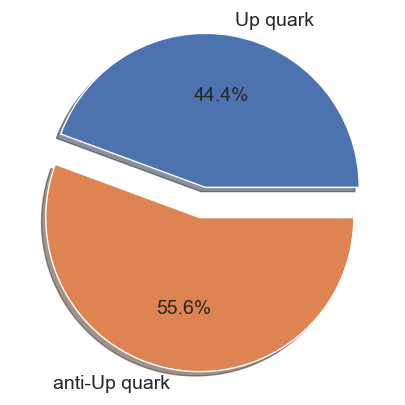

In [106]:
# ratio between flavours
sns.set_theme(style="white")
counts_ujet = final_df[final_df['jet_type'] == 1].shape[0]
counts_ubarjet = final_df[final_df['jet_type'] == 0].shape[0]
plt.figure(figsize=(7,5))
plt.pie([counts_ujet, counts_ubarjet], explode=[0.1,0.1], shadow=True, labels=['Up quark','anti-Up quark'], textprops={'fontsize': 14}, autopct='%1.1f%%');

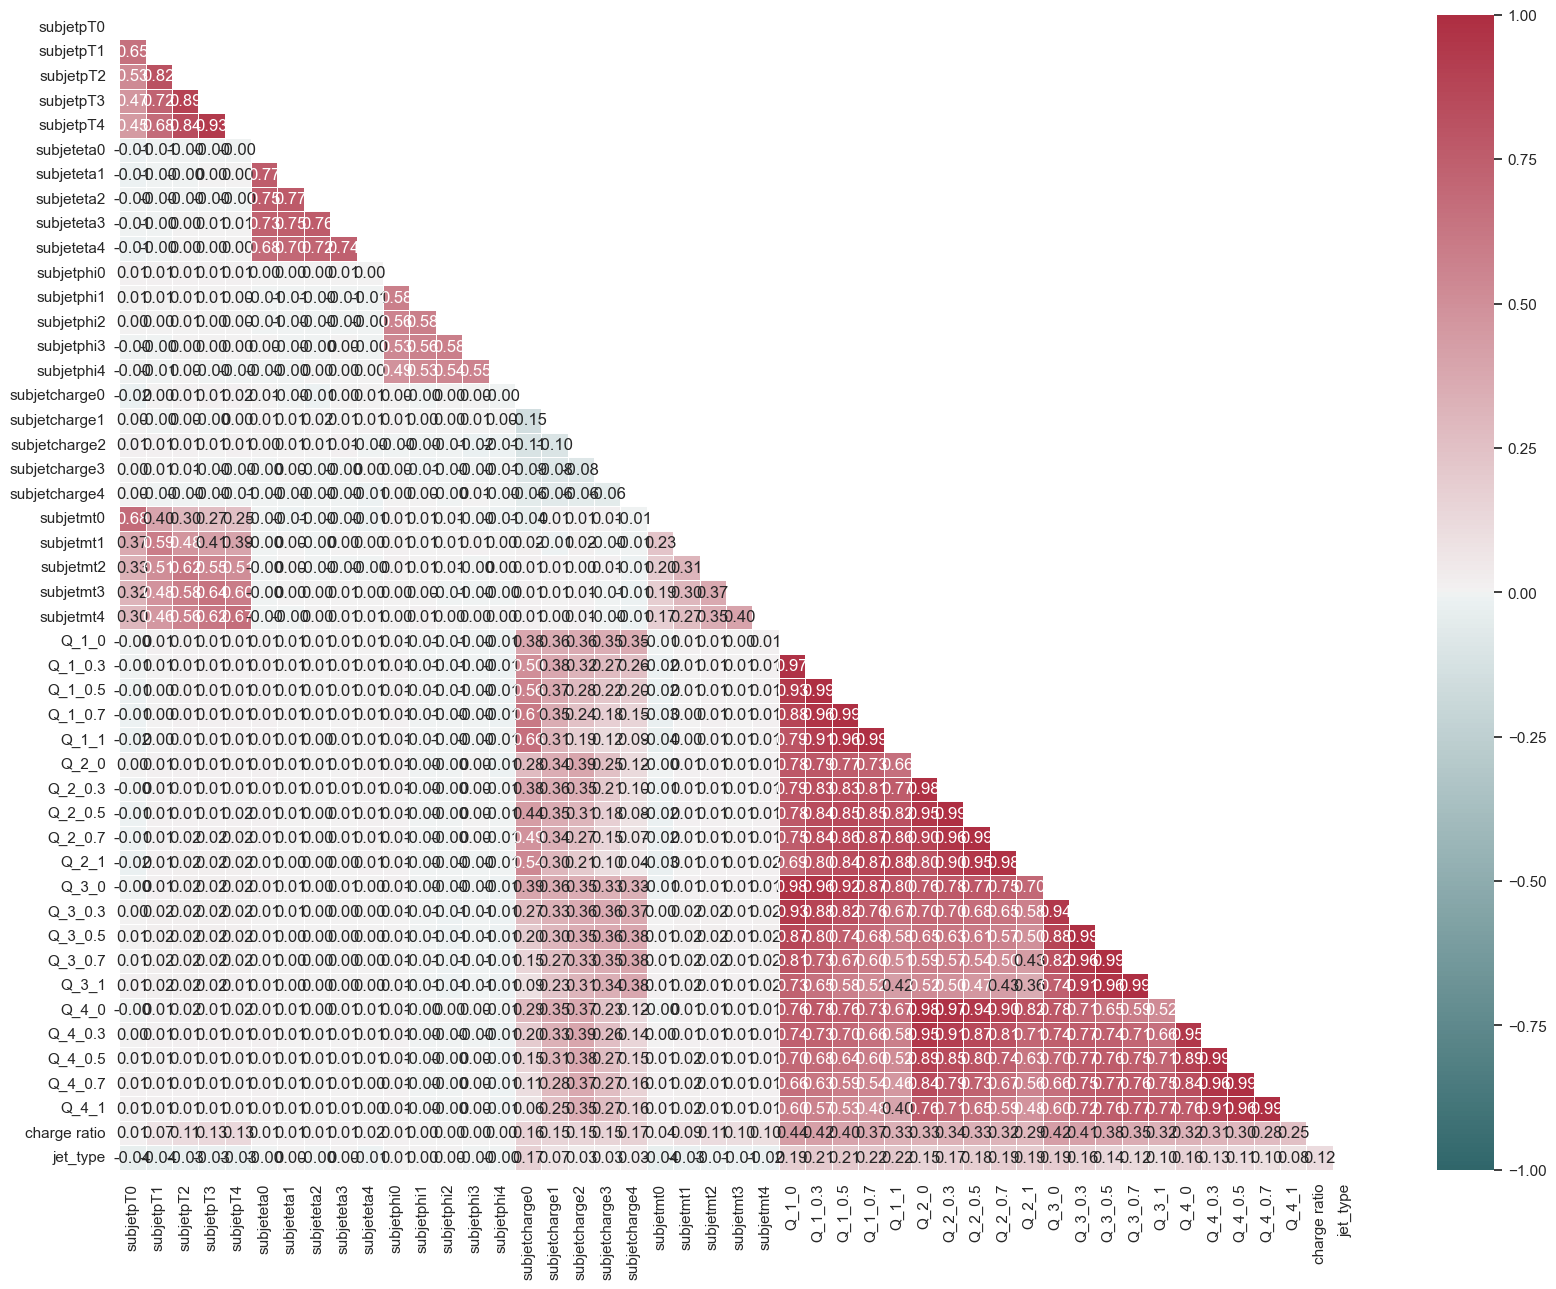

In [107]:
plt.figure(figsize=(20,15))
#sns.set_theme(style="white")

# Getting the Upper Triangle of the co-relation matrix
corr = final_df.corr()
#matrix = np.triu(corr)
#mask = np.triu(np.ones_like(corr, dtype=bool))
matrix = np.triu(np.ones_like(corr))


cmap = sns.diverging_palette(200, 7, s=75, l=40,
                            n=5, center="light", as_cmap=True)

#sns.heatmap(df_test.corr(), annot=True, linewidth=.5, vmin = -1, vmax = 1,cmap = plt.cm.CMRmap_r, fmt=".1f", mask=matrix);
sns.heatmap(final_df.corr(), annot=True, linewidth=.5, vmin = -1, vmax = 1,cmap = cmap, fmt=".2f", mask=matrix);

<Axes: >

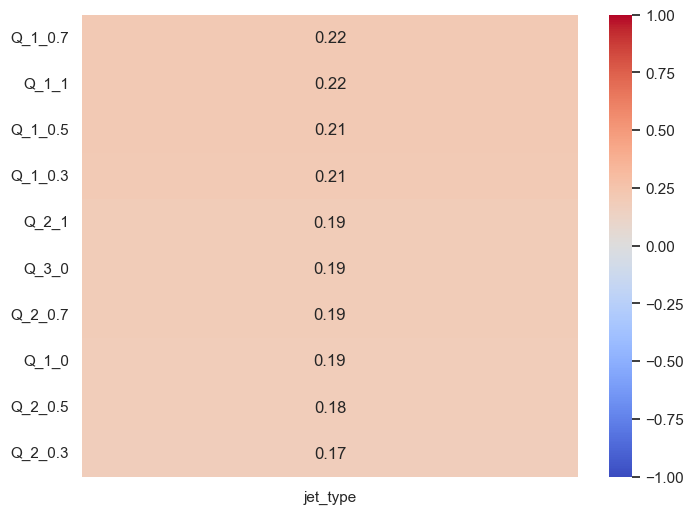

In [108]:
# plot variables with the highest correlation
plt.figure(figsize=(8,6))
corr = final_df.corr()
matrix = np.triu(np.ones_like(corr))
cmap = sns.diverging_palette(200, 7, s=75, l=40,
                            n=5, center="light", as_cmap=True)
corr_column = corr[['jet_type']].sort_values(by='jet_type', ascending=False)
sns.heatmap(corr_column[1:11], annot=True, cmap='coolwarm', vmin=-1, vmax=1)

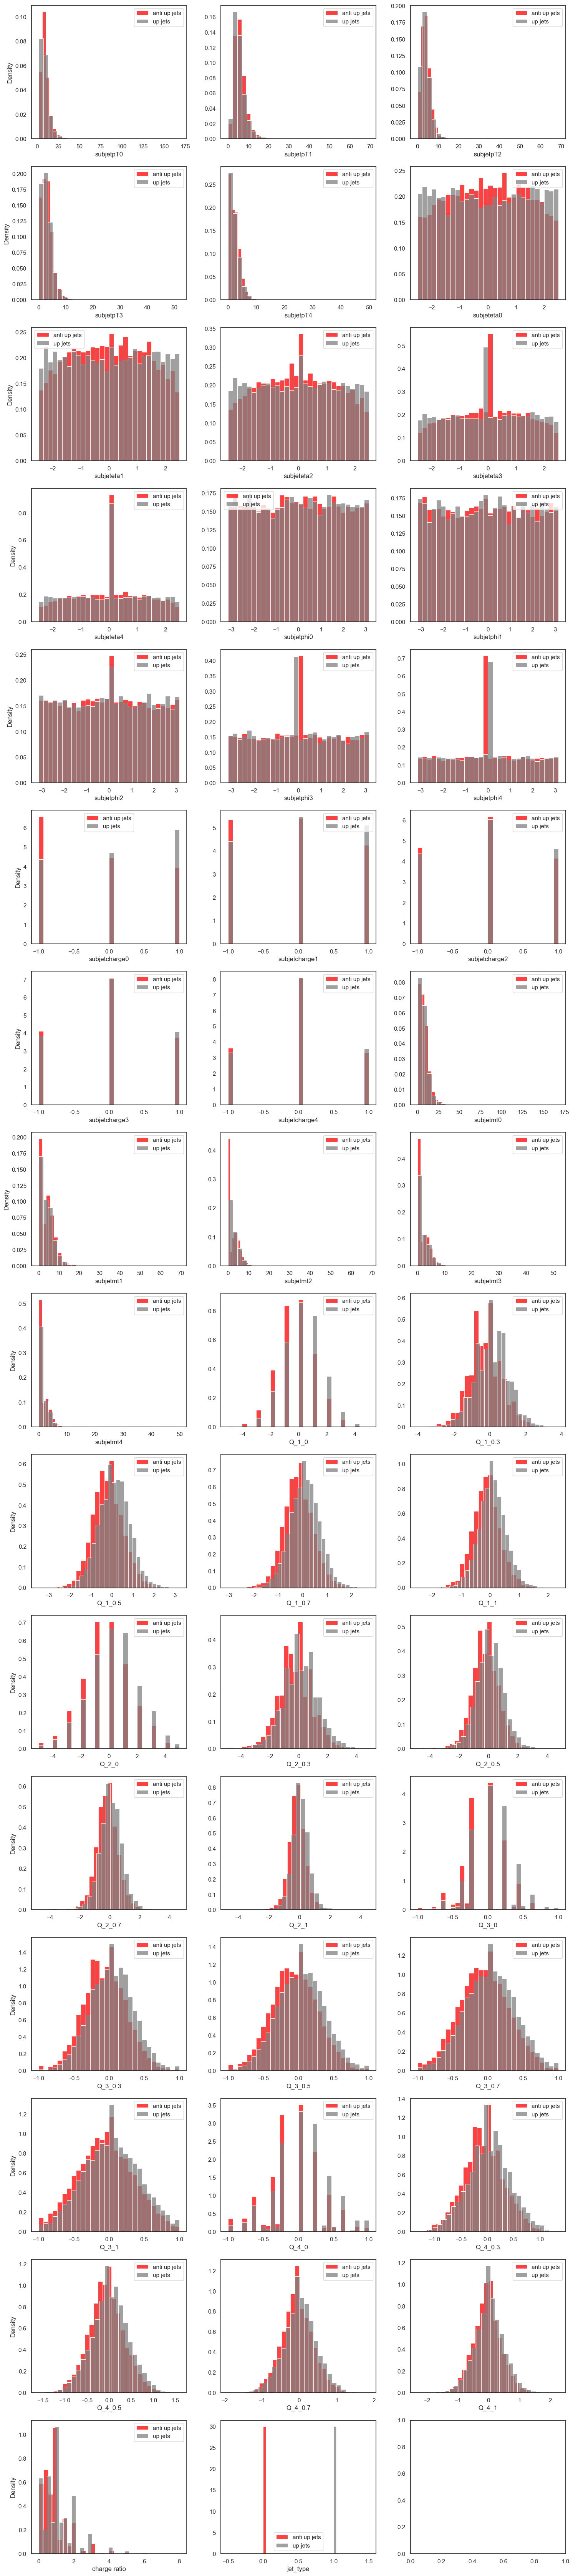

In [109]:
# Distributions of the float features
hist(final_df[final_df['jet_type']==0].replace(-999, np.nan),
     final_df[final_df['jet_type']==1].replace(-999, np.nan),
     #list(df_all.columns[df_all.dtypes == 'float64']),
     list(final_df.columns),
     bins = math.floor(len(final_df)**(1/3)),
     ncols = 3)

## Simple DNN

In [110]:
NDIM = len(final_df.keys()) - 1
dataset = final_df.values
X = dataset[:,0:NDIM]
Y = dataset[:,NDIM]

from sklearn.model_selection import train_test_split
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.2, random_state=7)

# preprocessing: standard scalar
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train_val)
X_train_val = scaler.transform(X_train_val)
X_test = scaler.transform(X_test)

# Check for NaNs/Infs in the dataset
X_train_val = np.nan_to_num(X_train_val)
X_test = np.nan_to_num(X_test)

# baseline keras model
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import SGD
#from keras.optimizers import SGD
from keras.layers import Input, Activation, Dense, Convolution2D, MaxPooling2D, Dropout, Flatten
#from keras.utils import np_utils
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from tensorflow import keras

inputs = Input(shape=(NDIM,), name = 'input') 
hidden1 = Dense(40, name = 'hidden1', kernel_initializer='normal', activation='relu')(inputs)
hidden2 = Dense(40, name = 'hidden2', kernel_initializer='normal', activation='relu')(hidden1)
outputs = Dense(1, name = 'output', kernel_initializer='normal', activation='sigmoid')(hidden2)

# create the model
model = Model(inputs=inputs, outputs=outputs)
# compile the model
optimizer = SGD(learning_rate=1e-4) # define the optimizer
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# print the model summary
model.summary()

# early stopping callback
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min')

# model checkpoint callback
# this saves our model architecture + parameters into dense_model.h5
from keras.callbacks import ModelCheckpoint
model_checkpoint = ModelCheckpoint('uubar.keras', monitor='val_loss', 
                                   verbose=0, save_best_only=True, 
                                   save_weights_only=False, mode='auto', 
                                   #period=1)
)

Model: "functional_2221"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 46)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden1 (Dense)                 │ (None, 40)             │         1,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden2 (Dense)                 │ (None, 40)             │         1,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            41 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,561 (13.91 KB)

 Trainable params: 3,561 (13.91 KB)

 Non-trainable params: 0 (0.00 B)

In [111]:
# Train classifier
import time
start = time.time() # time at start of whole processing

history = model.fit(X_train_val, 
                    Y_train_val, 
                    epochs=1000, 
                    batch_size=512, 
                    verbose=1, # switch to 1 for more verbosity 
                    callbacks=[early_stopping, model_checkpoint], 
                    validation_data=(X_test,Y_test))

elapsed = time.time() - start # time after whole processing
print("Time taken: "+str(round(elapsed,1))+"s") # print total time taken to process every file

Epoch 1/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5752 - loss: 0.6840 - val_accuracy: 0.6039 - val_loss: 0.6649
Epoch 2/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6054 - loss: 0.6609 - val_accuracy: 0.6016 - val_loss: 0.6619
Epoch 3/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6063 - loss: 0.6582 - val_accuracy: 0.6037 - val_loss: 0.6591
Epoch 4/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6132 - loss: 0.6542 - val_accuracy: 0.6042 - val_loss: 0.6560
Epoch 5/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6149 - loss: 0.6483 - val_accuracy: 0.6092 - val_loss: 0.6539
Epoch 6/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6191 - loss: 0.6474 - val_accuracy: 0.6092 - val_loss: 0.6508
Epoch 7/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6215 - loss: 0.6461 - val_accuracy: 0.6097 - val_loss: 0.6487
Epoch 8/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6271 - loss: 0.6426 - val_accuracy: 0.

177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step
706/706 ━━━━━━━━━━━━━━━━━━━━ 0s 630us/step


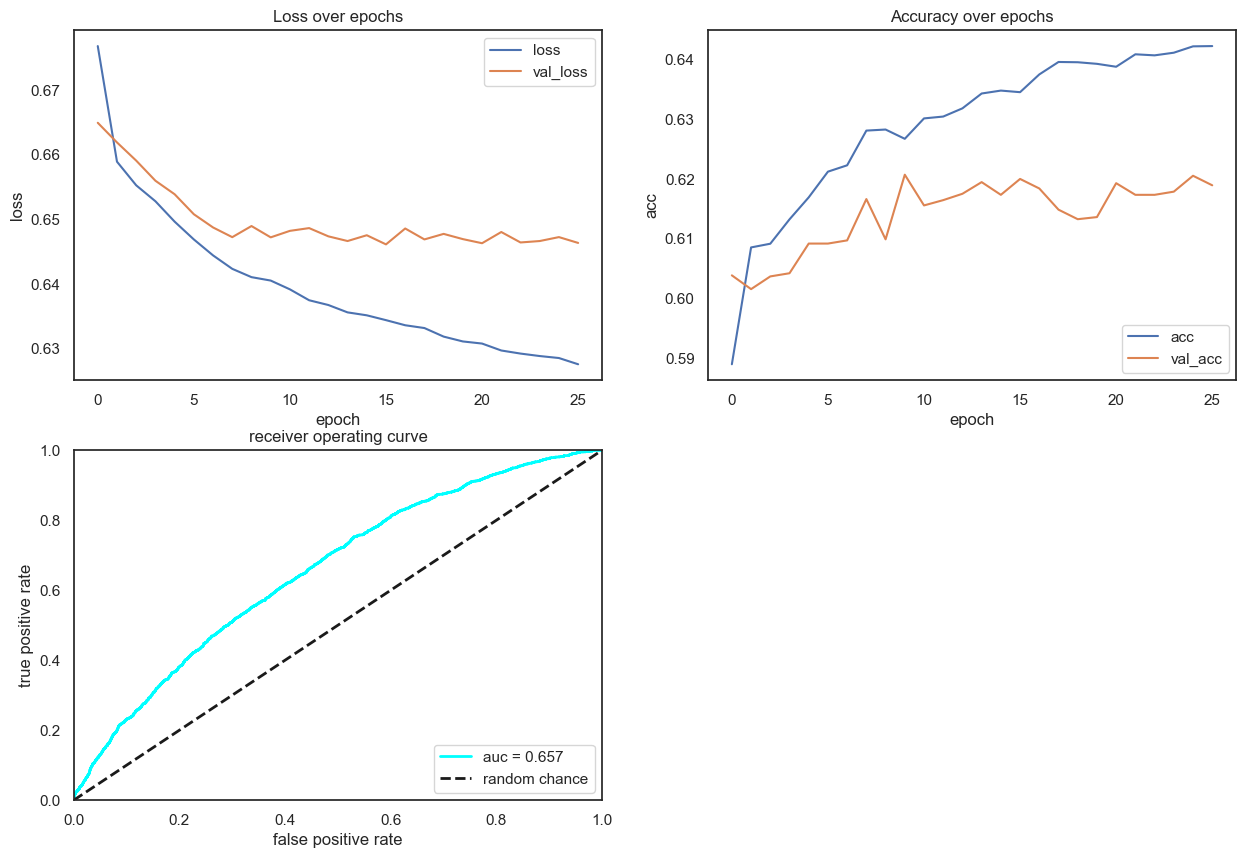

In [112]:
loss_accuracy_plotter(history, model, X_train_val, Y_train_val, X_test, Y_test)

In [113]:
fpr_nn, tpr_nn, thresholds_nn = evaluate(model, X_train_val, Y_train_val, X_test, Y_test)

177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step
706/706 ━━━━━━━━━━━━━━━━━━━━ 0s 633us/step
Test acc score: 0.6189294576391351
Train acc score: 0.647535897890445
Classification report for the test set
              precision    recall  f1-score   support

anti up jets       0.64      0.72      0.68      3185
     up jets       0.57      0.48      0.52      2457

    accuracy                           0.62      5642
   macro avg       0.61      0.60      0.60      5642
weighted avg       0.61      0.62      0.61      5642



## NN optimization

In [114]:
import numpy as np
from tensorflow import keras
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from scikeras.wrappers import KerasClassifier

# Ensure NDIM is defined
NDIM = len(final_df.keys()) - 1

# Define the function to make the model
def make_model(network_layers=(32, 32),
               dropout_rate=0.0,
               optimizer="Nadam",
               activation="selu",
               k_initializer='lecun_normal',
               n_input=NDIM,
               n_class=1):
    
    model = keras.models.Sequential()    
    model.add(keras.layers.Input(shape=(NDIM,)))

    for index, layers in enumerate(network_layers):
        model.add(keras.layers.Dense(layers,
                                         kernel_initializer=k_initializer,
                                         activation=activation))
        if dropout_rate > 0:
            model.add(keras.layers.Dropout(dropout_rate))
            #model.add(keras.layers.AlphaDropout(dropout_rate))

    model.add(keras.layers.Dense(n_class,
                                 activation="sigmoid"))
    
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model

# Define the main function for optimization
def opt_model():
    keras_pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", KerasClassifier(
            model=make_model,
            network_layers=(32, 32),  # Default values
            dropout_rate=0.0,         # Default values
            optimizer="Nadam",        # Default values
            activation="selu",        # Default values
            k_initializer='lecun_normal',  # Default values
            verbose=0,
            n_input=NDIM,
            n_class=1
        ))
    ])
    
    param_grid = {
        'clf__network_layers': [(32, 32), (32, 32, 32), (64, 64), (128, 128, 128)],
        'clf__batch_size': [64, 128, 256, 512],
        'clf__epochs': [5, 10, 15, 50, 100, 200],
        'clf__dropout_rate': [0.2, 0.1, 0.01],
        'clf__optimizer': ['Nadam', 'Adam', 'SGD'],
        'clf__activation': ['selu', 'relu', 'tanh'],
        'clf__k_initializer': ['lecun_normal', 'normal'],
        'clf__verbose': [0]
    }
    
    rs_keras = RandomizedSearchCV(
        keras_pipeline,
        param_distributions=param_grid,
        cv=5,
        refit=True,
        verbose=0,
        n_iter=5,
        scoring="accuracy"
    )
    
    history = rs_keras.fit(X_train_val, Y_train_val)
    
    print('Best score obtained: {0}'.format(rs_keras.best_score_))
    print('Parameters:')
    for param, value in rs_keras.best_params_.items():
        print('\t{}: {}'.format(param, value))
    
    return rs_keras  


# Set this to true if you want to optimize
do_opt = True
if do_opt:
    if __name__ == '__main__':
        optimal_model = opt_model()


Best score obtained: 0.6061423323165701
Parameters:
	clf__verbose: 0
	clf__optimizer: SGD
	clf__network_layers: (32, 32)
	clf__k_initializer: normal
	clf__epochs: 5
	clf__dropout_rate: 0.01
	clf__batch_size: 64
	clf__activation: tanh


In [115]:
# Packages for modeling
from keras import models
from keras import layers
from keras import regularizers

opt_model = models.Sequential()
opt_model.add(layers.Dense(32,  kernel_initializer='normal', activation='tanh', input_shape=(NDIM,)))
opt_model.add(layers.Dropout(0.01))
opt_model.add(layers.Dense(32,  kernel_initializer='normal', activation='tanh'))
opt_model.add(layers.Dropout(0.01))
opt_model.add(layers.Dense(1, kernel_initializer='normal', activation='sigmoid'))

# compile the model
opt_model.compile(optimizer='SGD', loss='binary_crossentropy', metrics=['accuracy'])
# print the model summary
opt_model.summary()

# early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min')

# Train classifier
import time
start = time.time() # time at start of whole processing

opt_history = opt_model.fit(X_train_val,
                    Y_train_val,
                    epochs=30,
                    batch_size=64,
                    verbose=1, # switch to 1 for more verbosity 
                    #callbacks=[early_stopping],
                    validation_data=(X_test,Y_test))

elapsed = time.time() - start # time after whole processing
print("Time taken: "+str(round(elapsed,1))+"s") # print total time taken to process every file

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_483"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1484 (Dense)              │ (None, 32)             │         1,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_206 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1485 (Dense)              │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_207 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1486 (Dense)              │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,593 (10.13 KB)

 Trainable params: 2,593 (10.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
353/353 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5415 - loss: 0.6904 - val_accuracy: 0.5643 - val_loss: 0.6821
Epoch 2/30
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5623 - loss: 0.6805 - val_accuracy: 0.5840 - val_loss: 0.6733
Epoch 3/30
353/353 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5881 - loss: 0.6732 - val_accuracy: 0.5989 - val_loss: 0.6664
Epoch 4/30
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6040 - loss: 0.6642 - val_accuracy: 0.6032 - val_loss: 0.6638
Epoch 5/30
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6119 - loss: 0.6602 - val_accuracy: 0.6048 - val_loss: 0.6627
Epoch 6/30
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6017 - loss: 0.6642 - val_accuracy: 0.6033 - val_loss: 0.6621
Epoch 7/30
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6134 - loss: 0.6574 - val_accuracy: 0.6016 - val_loss: 0.6616
Epoch 8/30
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6065 - loss: 0.6600 - val_accuracy: 0.

177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
706/706 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


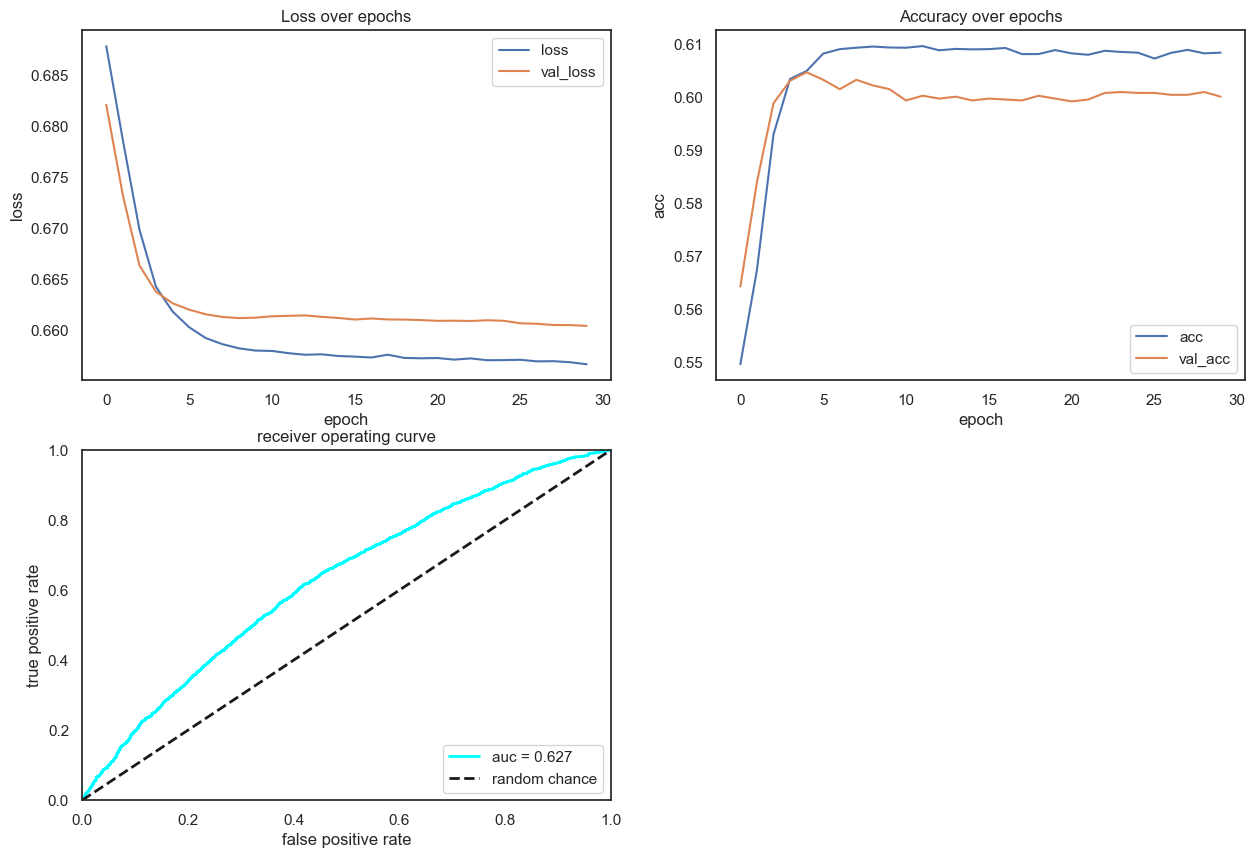

In [116]:
loss_accuracy_plotter(opt_history, opt_model, X_train_val, Y_train_val, X_test, Y_test)

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 638us/step


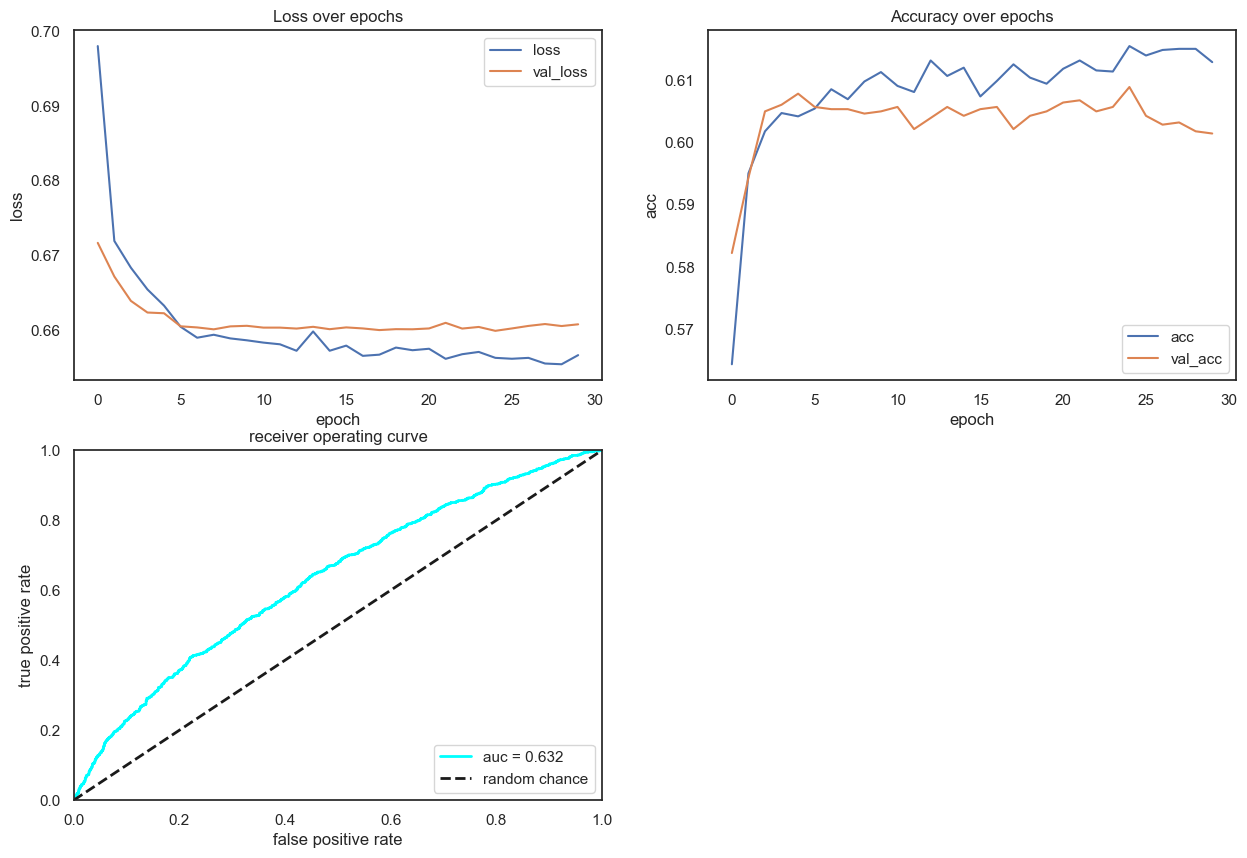

In [69]:
loss_accuracy_plotter(opt_history, opt_model, X_train_val, Y_train_val, X_test, Y_test)

In [117]:
fpr_nn, tpr_nn, thresholds_nn = evaluate(opt_model, X_train_val, Y_train_val, X_test, Y_test)

177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step
706/706 ━━━━━━━━━━━━━━━━━━━━ 1s 883us/step
Test acc score: 0.6001417936901808
Train acc score: 0.6088459492997695
Classification report for the test set
              precision    recall  f1-score   support

anti up jets       0.63      0.72      0.67      3185
     up jets       0.55      0.45      0.49      2457

    accuracy                           0.60      5642
   macro avg       0.59      0.58      0.58      5642
weighted avg       0.59      0.60      0.59      5642



## Other classifiers

In [138]:
# Count NaNs in each column
df_nonan = final_df.copy()
df_nonan = df_nonan.dropna()
#print(df_nonan.isna().sum())

### SVC

In [136]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

dataset_nonan = df_nonan.values
X = dataset_nonan[:,0:NDIM]
Y = dataset_nonan[:,NDIM]

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

svm_model = SVC(kernel='linear', C=1, random_state=42)  # Using a linear kernel and C=1 for simplicity
svm_model.fit(X_train, Y_train)

Y_pred = svm_model.predict(X_val)

accuracy = accuracy_score(Y_val, Y_pred)
classification_rep = classification_report(Y_val, Y_pred)
conf_matrix = confusion_matrix(Y_val, Y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_rep)
print("Confusion Matrix:")
print(conf_matrix)


Accuracy: 0.58
Classification Report:
              precision    recall  f1-score   support

         0.0       0.59      0.74      0.66      3064
         1.0       0.56      0.40      0.47      2561

    accuracy                           0.58      5625
   macro avg       0.58      0.57      0.56      5625
weighted avg       0.58      0.58      0.57      5625

Confusion Matrix:
[[2263  801]
 [1541 1020]]


### QSVC

In [134]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

classifiers = [
    KNeighborsClassifier(3),
    SVC(probability=True),
    DecisionTreeClassifier(),
 	RandomForestClassifier(criterion='gini', max_depth=8, n_estimators=30, random_state=420),
	AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression()]

log_cols = ["Classifier", "Accuracy"]
log 	 = pd.DataFrame(columns=log_cols)

sss = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=0)

acc_dict = {}

dataset_nonan = df_nonan.values
X = dataset_nonan[:,0:NDIM]
Y = dataset_nonan[:,NDIM]
for train_index, test_index in sss.split(X, Y):
	X_train, X_test = X[train_index], X[test_index]
	y_train, y_test = Y[train_index], Y[test_index]
	
	for clf in classifiers:
		name = clf.__class__.__name__
		clf.fit(X_train, y_train)
		train_predictions = clf.predict(X_test)
		acc = accuracy_score(y_test, train_predictions)	
		if name in acc_dict:
			acc_dict[name] += acc
		else:
			acc_dict[name] = acc

for clf in acc_dict:
	acc_dict[clf] = acc_dict[clf] / 10.0		# for 10 times accuracy is computed and the final accuracy is the average over 10
	log_entry = pd.DataFrame([[clf, acc_dict[clf]]], columns=log_cols)
	log = log.append(log_entry)

plt.xlabel('Accuracy')
plt.title('Classifier Accuracy')

sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b");

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:949: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i

AttributeError: 'DataFrame' object has no attribute 'append'

## Run MG5 and Pythia

In [ ]:
Run_MG5 = False
if Run_MG5:
    cmap = plt.get_cmap('gray_r')
    outdir = 'images_out/'
    if not os.path.isdir(outdir): os.system('mkdir {}'.format(outdir))
    cwd = os.getcwd()

    up_MG5 = False
    if up_MG5:
        write_mg_cards([500,700], nevents=nevents)
        ! cd /Users/mghasemi/Desktop/Code/Code/Generators/MG5_aMC_v2_9_18/; bin/mg5_aMC $cwd/generate_up.mg5

## plot charge distributions

'\n#Calculating the Gaussian PDF values given Gaussian parameters and random variable X\ndef gaus(X,C,X_mean,sigma):\n    return C*np.exp(-(X-X_mean)**2/(2*sigma**2))\n\nmean = sum(hist[1]*hist[0])/sum(hist[0])                  \nsigma = sum(hist[0]*(hist[1]-mean)**2)/sum(hist[0]) \nparam_optimised,param_covariance_matrix = curve_fit(gaus,hist[1],hist[0],p0=[max(hist[0]),mean,sigma],maxfev=5000)\n'

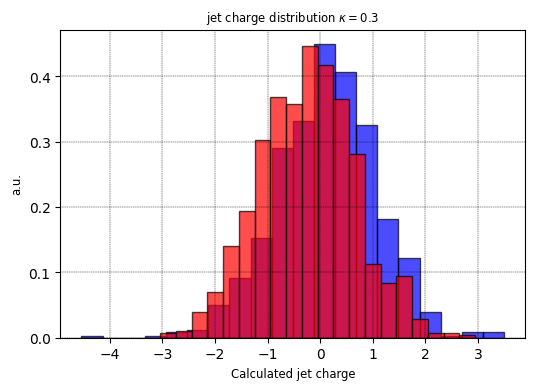

In [646]:
plt.figure(figsize=(6,4))
hist = plt.hist(test_wpT, bins=20, density=True, alpha=0.7, color='b', edgecolor='black')
plt.hist(test_wpTbar, bins=20, density=True, alpha=0.7, color='r', edgecolor='black')
plt.grid(color = 'black', linestyle = '--', linewidth = 0.3)
plt.title('jet charge distribution $\kappa=0.3$', fontsize = 'small')
plt.xlabel('Calculated jet charge', fontsize = 'small')
plt.ylabel('a.u.', fontsize = 'small')

'''
#Calculating the Gaussian PDF values given Gaussian parameters and random variable X
def gaus(X,C,X_mean,sigma):
    return C*np.exp(-(X-X_mean)**2/(2*sigma**2))

mean = sum(hist[1]*hist[0])/sum(hist[0])                  
sigma = sum(hist[0]*(hist[1]-mean)**2)/sum(hist[0]) 
param_optimised,param_covariance_matrix = curve_fit(gaus,hist[1],hist[0],p0=[max(hist[0]),mean,sigma],maxfev=5000)
'''

Text(0, 0.5, 'a.u.')

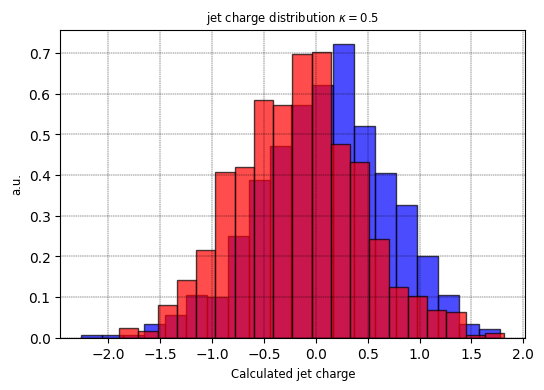

In [642]:
plt.figure(figsize=(6,4))
hist = plt.hist(test_wpT, bins=20, density=True, alpha=0.7, color='b', edgecolor='black')
plt.hist(test_wpTbar, bins=20, density=True, alpha=0.7, color='r', edgecolor='black')
plt.grid(color = 'black', linestyle = '--', linewidth = 0.3)
plt.title('jet charge distribution $\kappa=0.5$', fontsize = 'small')
plt.xlabel('Calculated jet charge', fontsize = 'small')
plt.ylabel('a.u.', fontsize = 'small')

Text(0, 0.5, 'a.u.')

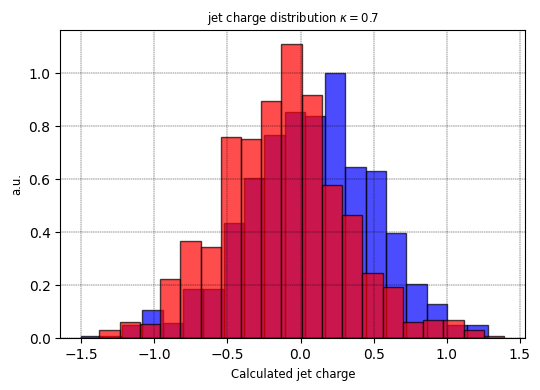

In [639]:
plt.figure(figsize=(6,4))
hist = plt.hist(test_wpT, bins=20, density=True, alpha=0.7, color='b', edgecolor='black')
plt.hist(test_wpTbar, bins=20, density=True, alpha=0.7, color='r', edgecolor='black')
plt.grid(color = 'black', linestyle = '--', linewidth = 0.3)
plt.title('jet charge distribution $\kappa=0.7$', fontsize = 'small')
plt.xlabel('Calculated jet charge', fontsize = 'small')
plt.ylabel('a.u.', fontsize = 'small')
#plt.xlim([-3, 3])

Text(0, 0.5, 'a.u.')

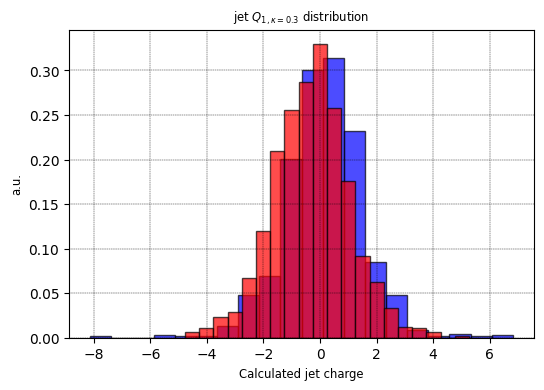

In [35]:
plt.figure(figsize=(6,4))
hist = plt.hist(test_Q_1kappa, bins=20, density=True, alpha=0.7, color='b', edgecolor='black')
plt.hist(test_Q_1kappa_bar, bins=20, density=True, alpha=0.7, color='r', edgecolor='black')
plt.grid(color = 'black', linestyle = '--', linewidth = 0.3)
plt.title('jet $Q_{1,\kappa=0.3}$ distribution', fontsize = 'small')
plt.xlabel('Calculated jet charge', fontsize = 'small')
plt.ylabel('a.u.', fontsize = 'small')

Text(0, 0.5, 'a.u.')

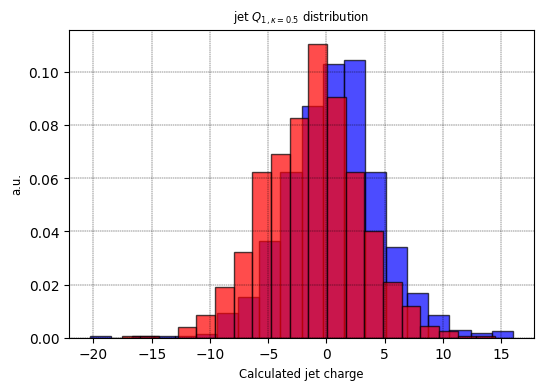

In [643]:
plt.figure(figsize=(6,4))
hist = plt.hist(test_Q_1kappa, bins=20, density=True, alpha=0.7, color='b', edgecolor='black')
plt.hist(test_Q_1kappa_bar, bins=20, density=True, alpha=0.7, color='r', edgecolor='black')
plt.grid(color = 'black', linestyle = '--', linewidth = 0.3)
plt.title('jet $Q_{1,\kappa=0.5}$ distribution', fontsize = 'small')
plt.xlabel('Calculated jet charge', fontsize = 'small')
plt.ylabel('a.u.', fontsize = 'small')

Text(0, 0.5, 'a.u.')

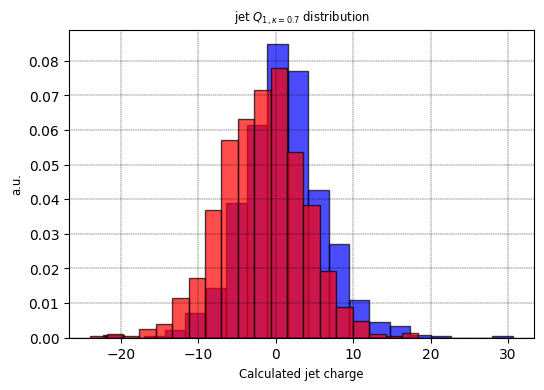

In [638]:
plt.figure(figsize=(6,4))
hist = plt.hist(test_Q_1kappa, bins=20, density=True, alpha=0.7, color='b', edgecolor='black')
plt.hist(test_Q_1kappa_bar, bins=20, density=True, alpha=0.7, color='r', edgecolor='black')
plt.grid(color = 'black', linestyle = '--', linewidth = 0.3)
plt.title('jet $Q_{1,\kappa=0.7}$ distribution', fontsize = 'small')
plt.xlabel('Calculated jet charge', fontsize = 'small')
plt.ylabel('a.u.', fontsize = 'small')

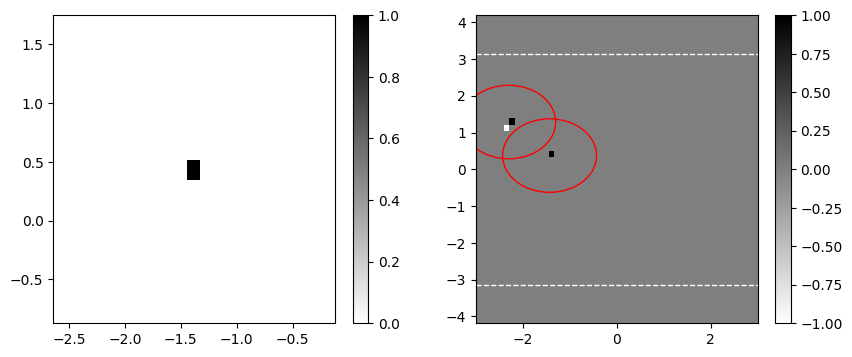

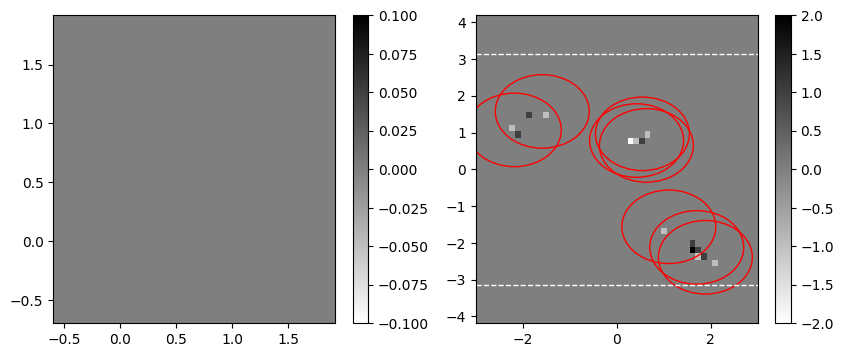

In [ ]:
lhe_file_name = './ug_unweighted_events.lhe.gz'
leading_jet_images, all_jet_images, jetpep, njet = run_pythia_get_images(lhe_file_name, nevents=5*10**3, plot_first_few=True)

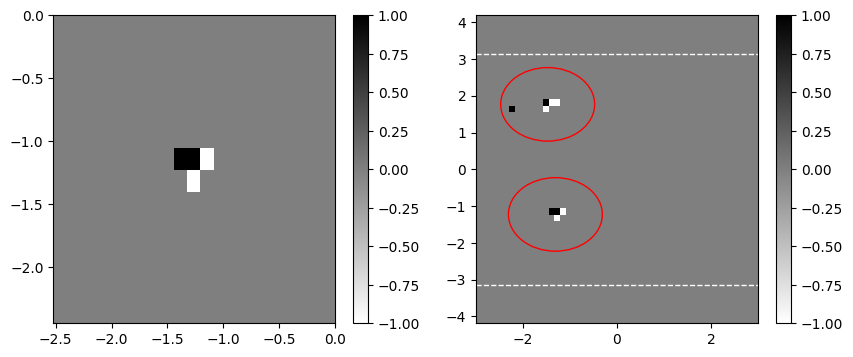

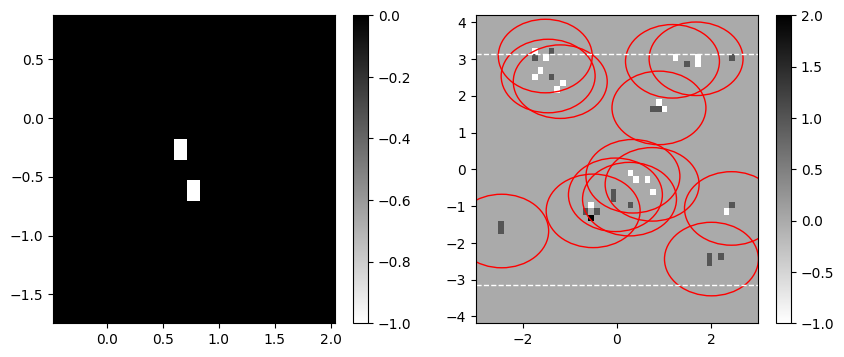

In [ ]:
lhe_file_name = './ubarg_unweighted_events.lhe.gz'
leading_jet_images_bar, all_jet_images_bar, jetpep_bar, njet_bar = run_pythia_get_images(lhe_file_name, nevents=5*10**3, plot_first_few=True)

In [ ]:
#print(all_jet_images[0])
print(len(njet))
print(type(leading_jet_images))
print(type(all_jet_images))
print(type(jetpep))
print(len(leading_jet_images))
print(leading_jet_images[0].shape)
print(all_jet_images[0][0].shape)

4428
<class 'list'>
<class 'list'>
<class 'list'>
4428
(15, 21)
(48, 50)


In [ ]:
import pickle

# Save to a binary file
save_to_file = False
if save_to_file:
    with open(outdir+'up_leading_jet.pkl', 'wb') as file:
        pickle.dump(leading_jet_images, file)
    with open(outdir+'up_all_jet.pkl', 'wb') as file:
        pickle.dump(leading_jet_images, file)
    with open(outdir+'up_jetpep_jet.pkl', 'wb') as file:
        pickle.dump(leading_jet_images, file)        

    with open(outdir+'upbar_leading_jet.pkl', 'wb') as file:
        pickle.dump(leading_jet_images_bar, file)
    with open(outdir+'upbar_all_jet.pkl', 'wb') as file:
        pickle.dump(leading_jet_images_bar, file)
    with open(outdir+'upbar_jetpep_jet.pkl', 'wb') as file:
        pickle.dump(leading_jet_images_bar, file)  

## np.Hist2D (for test)

In [ ]:
print(phiedges.shape)
print(etaedges.shape)

(49,)
(51,)


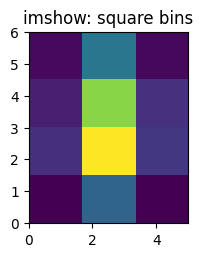

In [ ]:
from matplotlib.image import NonUniformImage
import matplotlib.pyplot as plt

xedges = [0, 1, 3, 5]
yedges = [0, 2, 3, 4, 6]
#x = np.random.normal(mu=2, sigma=1, size=100)
x = np.random.normal(2, 1, 2000)
y = np.random.normal(3, 1, 2000)
weights = np.random.normal(1, 1, 2000)
H, xedges, yedges = np.histogram2d(x, y, bins=(xedges, yedges), weights=weights)
# Histogram does not follow Cartesian convention (see Notes),
# therefore transpose H for visualization purposes.
H = H.T

fig = plt.figure(figsize=(7, 3))
ax = fig.add_subplot(131, title='imshow: square bins')
plt.imshow(H, interpolation='nearest', origin='lower',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

In [ ]:
print(H)
print(H.shape)
print(type(H))

[[ 35.95733433 190.17393659  34.5208922 ]
 [ 99.1586241  516.25109696 112.68437128]
 [ 76.67369562 430.82547259 102.81178273]
 [ 47.5011651  224.41473281  45.3618157 ]]
(4, 3)
<class 'numpy.ndarray'>


In [ ]:
print(H.shape)
K = pad_image(H)
print(K.shape)

(4, 3)
(16, 22)


In [ ]:
a = [1, 2, 3, 4, 5]
print(np.pad(a, (2, 3), 'constant', constant_values=(4, 6)))
print(np.pad(a, (2, 3), 'constant'))

[4 4 1 2 3 4 5 6 6 6]
[0 0 1 2 3 4 5 0 0 0]


In [ ]:
H + 1

array([[ 36.95733433, 191.17393659,  35.5208922 ],
       [100.1586241 , 517.25109696, 113.68437128],
       [ 77.67369562, 431.82547259, 103.81178273],
       [ 48.5011651 , 225.41473281,  46.3618157 ]])

In [ ]:
print(sum(H))
print(sum(sum(H)))

[ 259.29081914 1361.66523895  295.37886192]
1916.334920009921


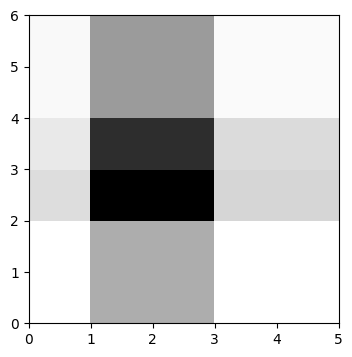

In [ ]:
fig, (ax1) = plt.subplots(1,1, figsize=(4,4))
ax1.pcolor(xedges, yedges, H, cmap=cmap)

## plot some jets

In [ ]:
load_file = False
if load_file:
    leading_jet_images = np.load(outdir+'tt_leading_jet.npz', allow_pickle=True)['arr_0']
    all_jet_images = np.load(outdir+'tt_all_jets.npz', allow_pickle=True)['arr_0']
    jetpep = np.load(outdir+'tt_jetpep.npz', allow_pickle=True)['arr_0']

    leading_jet_images0 = np.load(outdir+'qcd_leading_jet.npz', allow_pickle=True)['arr_0']
    all_jet_images0 = np.load(outdir+'qcd_all_jets.npz', allow_pickle=True)['arr_0']
    jetpep0 = np.load(outdir+'qcd_jetpep.npz', allow_pickle=True)['arr_0']

Pad leading jet images so they all have the same pixels.

In [ ]:
std_jet_images = list(map(pad_image, leading_jet_images))
std_jet_images_bar = list(map(pad_image, leading_jet_images_bar))

In [ ]:
print(len(leading_jet_images))
print(leading_jet_images[0].shape)
print(len(std_jet_images))
print(std_jet_images[0].shape)
#print(std_jet_images[0])
#print(leading_jet_images[0])

4428
(15, 21)
4428
(16, 22)


Plot a few events, first only the leading jet and then the whole event

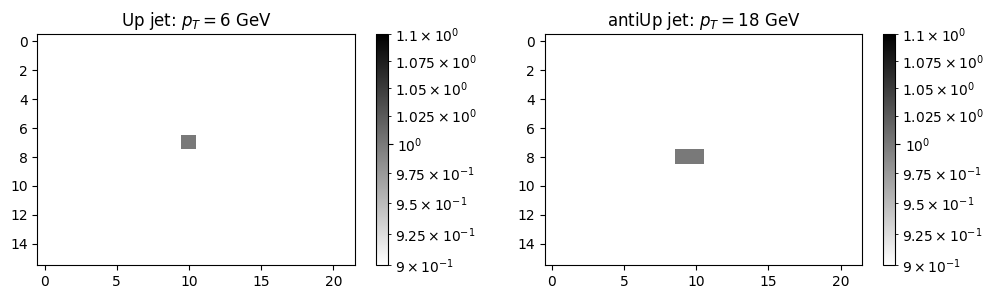

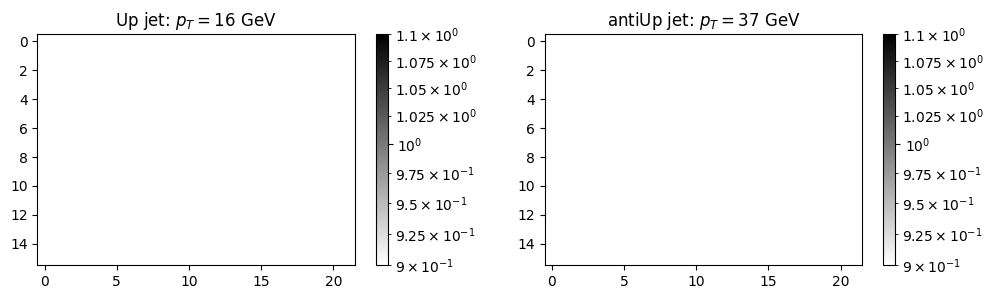

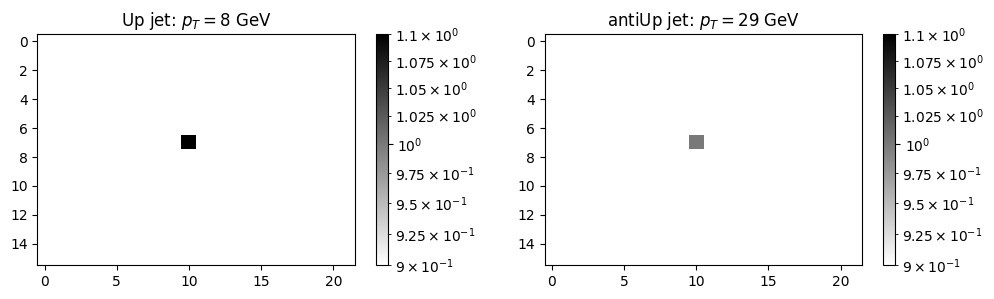

In [ ]:
logscale = True
logscale = dict(norm=mpl.colors.LogNorm()) if logscale else {}

for idx in range(3):
    fig, (axes1, axes2) = plt.subplots(1,2, figsize=(12,3))    
    im1 = axes1.imshow(std_jet_images[idx], cmap=cmap, **logscale)
    plt.colorbar(im1, ax=axes1)
    axes1.set(title='{} jet: $p_T=${:.0f} GeV'.format('Up', jetpep[idx][0][0]))
    im2 = axes2.imshow(std_jet_images_bar[idx], cmap=cmap, **logscale)
    plt.colorbar(im2, ax=axes2)
    axes2.set(title='{} jet: $p_T=${:.0f} GeV'.format('antiUp', jetpep_bar[idx][0][0]))      

Normalizing the histogram values in 0-255 range: only differences are seen if I use log scale, in which case a bunch of soft energy deposits disappear. The classifier should not care about smaller changes (do not fit the noise!)

In [ ]:
histo = np.array([1,2,3,50,60,100])
(histo/np.max(histo)*255).astype(int)

array([  2,   5,   7, 127, 153, 255])

In [ ]:
np.max(std_jet_images[0])
def normalize(histo, multi=255):

    return (histo/np.max(histo)*multi).astype(int) if np.max(histo)!=0 else histo
norm_jet_images_bar = list(map(normalize, std_jet_images_bar))

In [ ]:
#all_jet_images = list(map(normalize, all_jet_images))
norm_jet_images = list(map(normalize, std_jet_images))

#all_jet_images_bar = list(map(normalize, all_jet_images_bar))
norm_jet_images_bar = list(map(normalize, std_jet_images_bar))

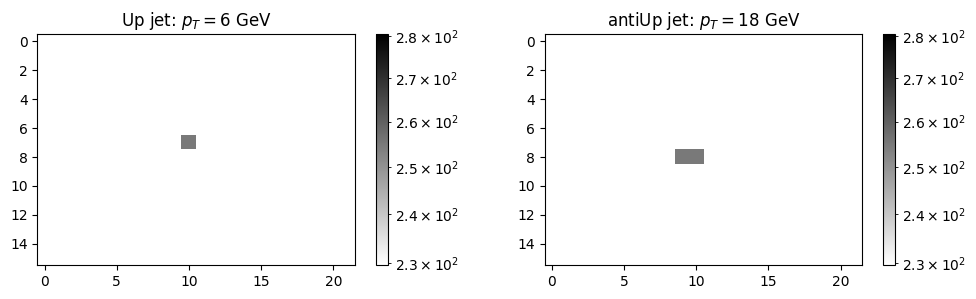

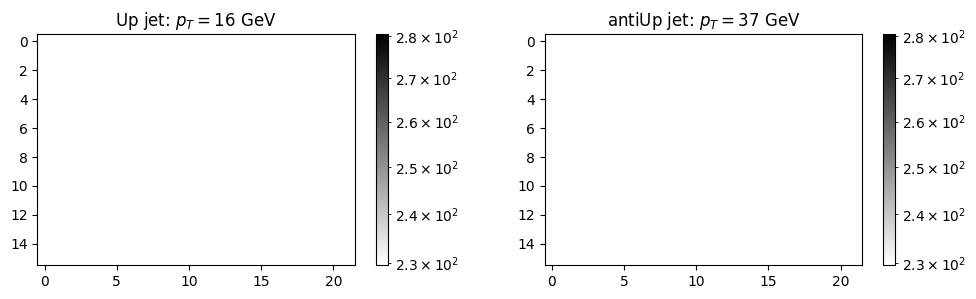

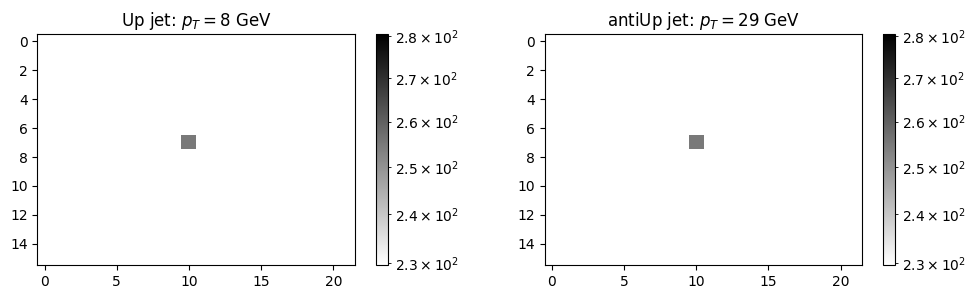

In [ ]:
logscale = True
logscale = dict(norm=mpl.colors.LogNorm()) if logscale else {}

for idx in range(3):
    fig, axes = plt.subplots(1,2, figsize=(12,3))    
    for iax, ax in enumerate(axes):
        im = ax.imshow([norm_jet_images, norm_jet_images_bar][iax][idx], cmap=cmap, **logscale)
        plt.colorbar(im, ax=ax)

        ax.set(title='{} jet: $p_T=${:.0f} GeV'.format(['Up','antiUp'][iax], [jetpep,jetpep_bar][iax][idx][0][0]))

### More plots

Plotting whole events in the $\eta-\phi$ plane. Also draw a circle around each jet, with opacity set by jet pT

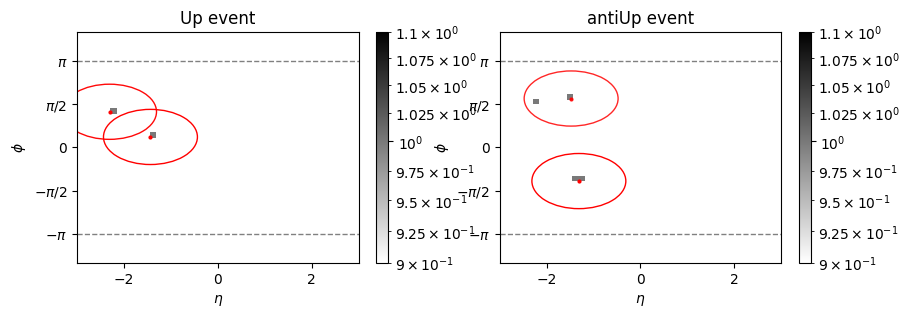

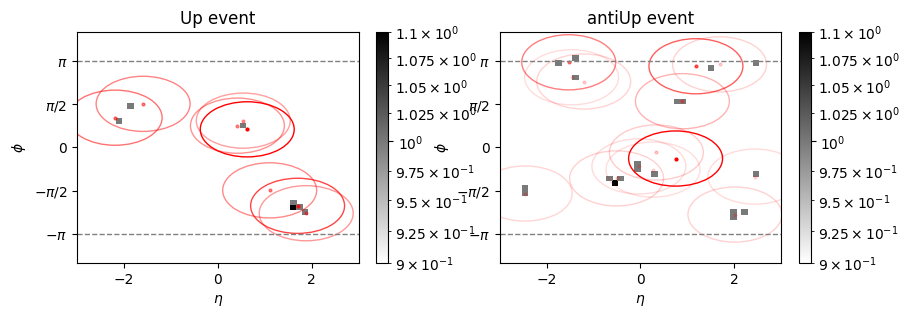

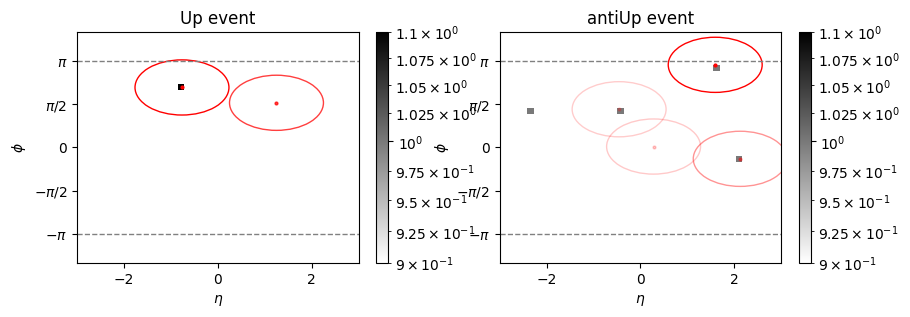

In [ ]:
logscale = True
logscale = dict(norm=mpl.colors.LogNorm()) if logscale else {}

for idx in range(3):
    fig, axes = plt.subplots(1,2, figsize=(10,3))    
    for iax, ax in enumerate(axes):
        im = ax.pcolor(etaedges, phiedges, sum([all_jet_images, all_jet_images_bar][iax][idx]), cmap=cmap, **logscale)
        plt.colorbar(im, ax=ax)
        jets = [jetpep[idx], jetpep_bar[idx]][iax]
        for j in jets:
            ax.add_artist(plt.Circle((j[1],j[2]),1, color='r', fill=False, alpha=j[0]/max([jj[0] for jj in jets])))
            ax.scatter(j[1],j[2], s=4, c='r', alpha=j[0]/max([jj[0] for jj in jets]))
        ax.set(title='{} event'.format(['Up','antiUp'][iax]), xlabel='$\eta$', ylabel='$\phi$', yticks=np.linspace(-np.pi, np.pi,5), 
               yticklabels=['$-\pi$','$-\pi/2$',0,'$\pi/2$','$\pi$'])
        for h in [-np.pi, np.pi]: 
            ax.axhline(h, ls='--', lw=1, c='gray')

Compare average images:

In [ ]:
list1 = [[1,2,3,4], [1,2,3,4]]
np.average(list1, axis=0)

array([1., 2., 3., 4.])

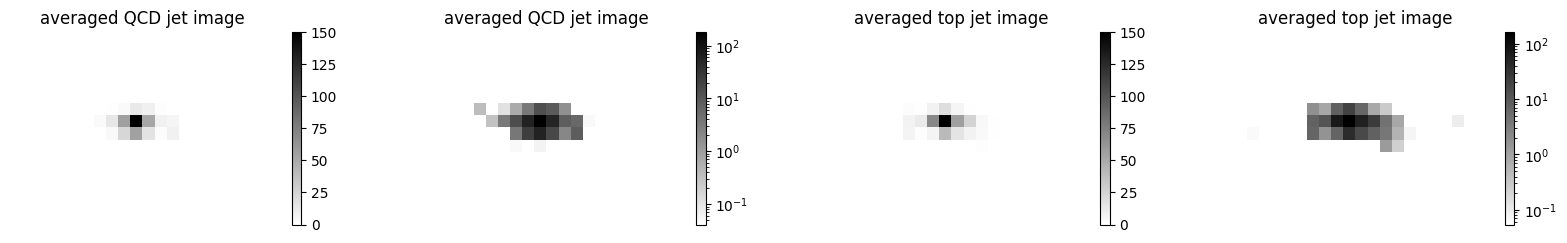

In [ ]:
fig, axes = plt.subplots(1,4,figsize=(20,2.5))
ims = [0]*len(axes)
ims[0]=axes[0].imshow(np.average(std_jet_images_bar, axis=0), vmin=0, vmax=150,cmap=cmap)
ims[1]=axes[1].imshow(np.average(std_jet_images_bar, axis=0), norm=mpl.colors.LogNorm(),cmap=cmap)
ims[2]=axes[2].imshow(np.average(std_jet_images, axis=0), vmin=0, vmax=150,cmap=cmap)
ims[3]=axes[3].imshow(np.average(std_jet_images, axis=0), norm=mpl.colors.LogNorm(),cmap=cmap)

for iax, ax in enumerate(axes):
    plt.colorbar(ims[iax], ax=ax)
    ax.set_axis_off(); 
    ax.set(title='averaged {} jet image'.format(['QCD','top'][iax//2]))

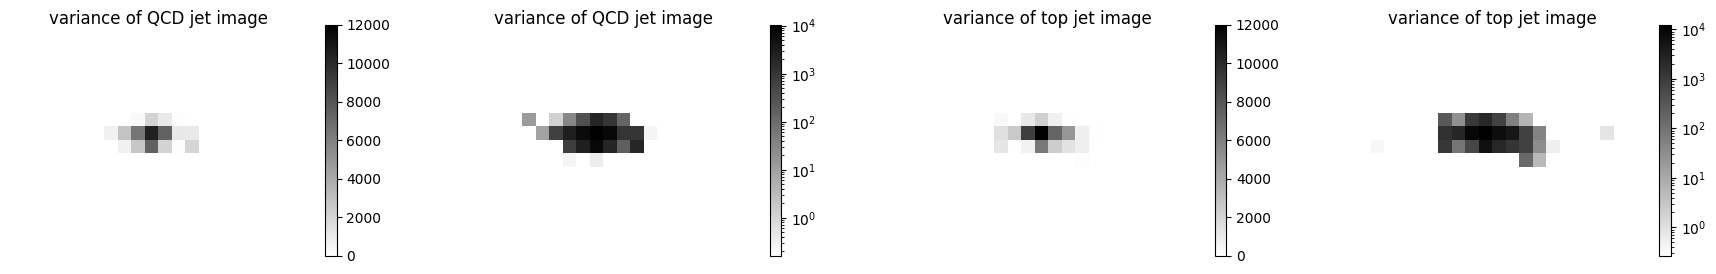

In [ ]:
fig, axes = plt.subplots(1,4,figsize=(22,3))
ims = [0]*len(axes)
ims[0]=axes[0].imshow(np.var(std_jet_images_bar, axis=0), vmax=12000,cmap=cmap)
ims[1]=axes[1].imshow(np.var(std_jet_images_bar, axis=0), norm=mpl.colors.LogNorm(),cmap=cmap)
ims[2]=axes[2].imshow(np.var(std_jet_images, axis=0), vmax=12000,cmap=cmap)
ims[3]=axes[3].imshow(np.var(std_jet_images, axis=0), norm=mpl.colors.LogNorm(),cmap=cmap)

for iax, ax in enumerate(axes):
    plt.colorbar(ims[iax], ax=ax)
    ax.set_axis_off(); 
    ax.set(title='variance of {} jet image'.format(['QCD','top'][iax//2]))

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(10,3))
ims = [0]*len(axes)
ims[0]=axes[0].pcolor(etaedges, phiedges, np.average(map(sum,all_jet_images_bar), axis=0), vmax=1.2,cmap=cmap)
ims[1]=axes[1].pcolor(etaedges, phiedges, np.average(map(sum,all_jet_images), axis=0), vmax=1.2,cmap=cmap)

for iax, ax in enumerate(axes):
    plt.colorbar(ims[iax], ax=ax)
    ax.set(xlabel='$\eta$',ylabel='$\phi$') 
    ax.set(title='averaged {} calorimeter image'.format(['QCD','ttbar'][iax]))

# Training neural networks

We will here train the neural networks for classifying between QCD jets and top quark jets. The trainig itself was done on a [Colab notebook](https://colab.research.google.com/) with TPU support to train the networks faster than on my laptop.

## run on Colab

In [ ]:
print(std_jet_images_bar[0].shape)
print(std_jet_images[0].shape)
test = np.array([1,2,3,4])
index = np.random.permutation(len(test))
test[index]

(16, 22)
(16, 22)


array([2, 3, 4, 1])

In [ ]:
indices

array([6217, 8126, 4710, ..., 4859, 3264, 2732])

In [ ]:
y_data_shuffled[0:20]

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [ ]:
import keras
#data0 = np.load(outdir+'qcd_leading_jet.npz', allow_pickle=True)['arr_0']
#data1 = np.load(outdir+'tt_leading_jet.npz', allow_pickle=True)['arr_0']
data0 = std_jet_images
data1 = std_jet_images_bar

print('We have {} Up jets and {} anti-Up jets'.format(len(data0), len(data1)))
x_data = np.concatenate((data0, data1))

y_data = np.array([0]*len(data0)+[1]*len(data1))

np.random.seed(0) # for reproducibility
# Ensure the same permutation is applied to both arrays
indices = np.random.permutation(len(x_data))

# Apply the permutation to both arrays
x_data_shuffled = x_data[indices]
y_data_shuffled = y_data[indices]

# the data coming out of previous commands is a list of 2D arrays. We want a 3D np array (n_events, xpixels, ypixels)
x_data_shuffled = np.stack(x_data_shuffled)

print('before:', x_data_shuffled.shape, y_data_shuffled.shape)

# reshape for tensorflow: x_data.shape + (1,) = shortcut for (x_data.shape[0], 16, 22, 1)
x_data_shuffled = x_data_shuffled.reshape(x_data_shuffled.shape + (1,)).astype('float32')
x_data_shuffled /= 255.

y_data_shuffled = keras.utils.to_categorical(y_data_shuffled, 2)

print('after:', x_data_shuffled.shape, y_data_shuffled.shape)

n_train = 6000
(x_train, x_test) = x_data_shuffled[:n_train], x_data_shuffled[n_train:]
(y_train, y_test) = y_data_shuffled[:n_train], y_data_shuffled[n_train:]

print('We will train+validate on {0} images ({1:.2f}%), leaving {2} iamges ({3:.2f}) for cross-validation'\
      .format(n_train,n_train/len(x_data),len(x_data)-n_train, (len(x_data)-n_train)/len(x_data)))

We have 4428 Up jets and 4757 anti-Up jets
before: (9185, 16, 22) (9185,)
after: (9185, 16, 22, 1) (9185, 2)
We will train+validate on 6000 images (0.65%), leaving 3185 iamges (0.35) for cross-validation


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Activation, Conv2D, MaxPooling2D

### Logostic model

In [ ]:
%%time
model0 = Sequential()
model0.add(Flatten(input_shape=(16, 22, 1)))  # Images are a 3D matrix, we have to flatten them to be 1D
model0.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))

# Compile model
model0.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history_logi = model0.fit(x_train, y_train, validation_split=0.2, epochs=40, batch_size=100, shuffle=True, verbose=0)

CPU times: user 4.93 s, sys: 505 ms, total: 5.43 s
Wall time: 4.82 s


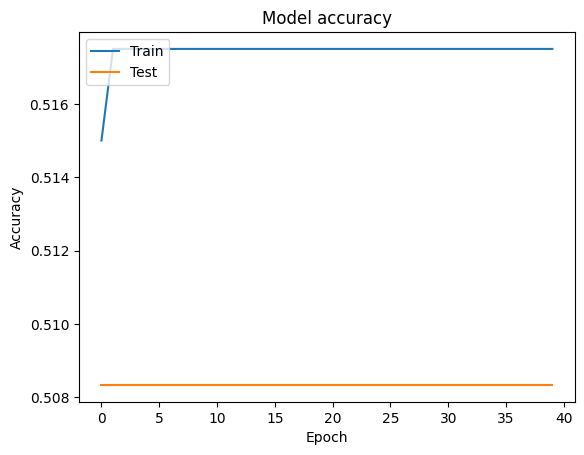

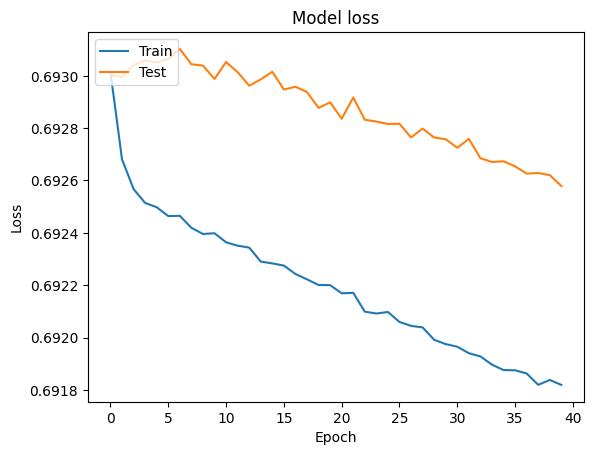

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history_logi.history['accuracy'])
plt.plot(history_logi.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history_logi.history['loss'])
plt.plot(history_logi.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### Simple MLP model

In [ ]:
%%time
model1 = Sequential()
model1.add(Flatten(input_shape=(16, 22, 1)))  # Images are a 3D matrix, we have to flatten them to be 1D
model1.add(Dense(100, kernel_initializer='normal', activation='tanh'))
model1.add(Dropout(0.5)) # drop a unit with  50% probability.

model1.add(Dense(100, kernel_initializer='orthogonal',activation='tanh'))
model1.add(Dropout(0.5)) # drop a unit with  50% probability.

model1.add(Dense(100, kernel_initializer='orthogonal',activation='tanh'))
# model.add(Activation('sigmoid'))
model1.add(Dense(1, kernel_initializer='normal', activation='sigmoid')) # last layer, this has a softmax to do the classification

model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history_mlp = model1.fit(x_train, y_train, validation_split=0.2, epochs=40, batch_size=100, shuffle=True, verbose=1)

Epoch 1/40
48/48 [==============================] - 1s 10ms/step - loss: 0.6930 - accuracy: 0.5088 - val_loss: 0.6933 - val_accuracy: 0.5083
Epoch 2/40
48/48 [==============================] - 0s 8ms/step - loss: 0.6928 - accuracy: 0.5167 - val_loss: 0.6931 - val_accuracy: 0.5083
Epoch 3/40
48/48 [==============================] - 0s 8ms/step - loss: 0.6927 - accuracy: 0.5129 - val_loss: 0.6935 - val_accuracy: 0.5083
Epoch 4/40
48/48 [==============================] - 0s 4ms/step - loss: 0.6926 - accuracy: 0.5215 - val_loss: 0.6931 - val_accuracy: 0.4917
Epoch 5/40
48/48 [==============================] - 0s 4ms/step - loss: 0.6928 - accuracy: 0.5108 - val_loss: 0.6931 - val_accuracy: 0.5083
Epoch 6/40
48/48 [==============================] - 0s 5ms/step - loss: 0.6929 - accuracy: 0.5152 - val_loss: 0.6932 - val_accuracy: 0.5083
Epoch 7/40
48/48 [==============================] - 0s 4ms/step - loss: 0.6925 - accuracy: 0.5175 - val_loss: 0.6932 - val_accuracy: 0.5083
Epoch 8/40
48/48 [=

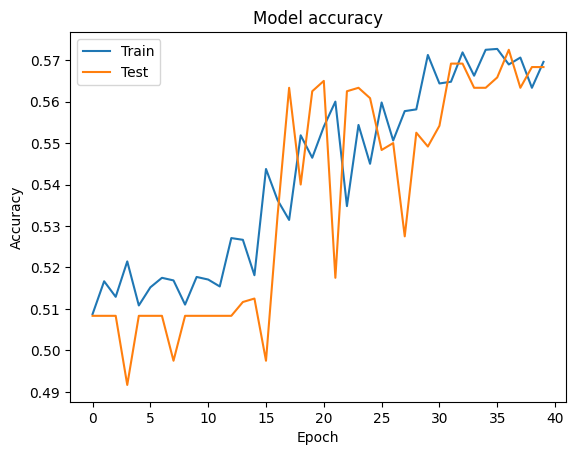

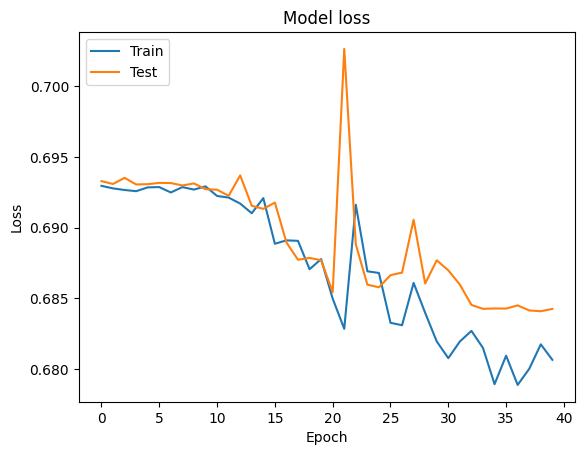

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history_mlp.history['accuracy'])
plt.plot(history_mlp.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history_mlp.history['loss'])
plt.plot(history_mlp.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### CNN model

In [ ]:
%%time
model_cnn = Sequential()
model_cnn.add(Conv2D(32, (3, 3), input_shape=(16, 22, 1), activation='relu'))
model_cnn.add(Conv2D(32, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(Dropout(0.25))

model_cnn.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model_cnn.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(Dropout(0.25))

model_cnn.add(Flatten())
model_cnn.add(Dense(300, activation='relu'))
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(1, activation='sigmoid'))

# Compile model
model_cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history_cnn = model_cnn.fit(x_train, y_train, validation_split=0.2, epochs=40, batch_size=100, shuffle=True, verbose=1)

Epoch 1/40
48/48 [==============================] - 4s 62ms/step - loss: 0.6927 - accuracy: 0.5160 - val_loss: 0.6931 - val_accuracy: 0.5083
Epoch 2/40
48/48 [==============================] - 3s 59ms/step - loss: 0.6929 - accuracy: 0.5175 - val_loss: 0.6930 - val_accuracy: 0.5083
Epoch 3/40
48/48 [==============================] - 3s 61ms/step - loss: 0.6929 - accuracy: 0.5181 - val_loss: 0.6931 - val_accuracy: 0.5083
Epoch 4/40
48/48 [==============================] - 3s 62ms/step - loss: 0.6925 - accuracy: 0.5175 - val_loss: 0.6932 - val_accuracy: 0.5083
Epoch 5/40
48/48 [==============================] - 3s 68ms/step - loss: 0.6929 - accuracy: 0.5175 - val_loss: 0.6932 - val_accuracy: 0.5083
Epoch 6/40
48/48 [==============================] - 3s 66ms/step - loss: 0.6926 - accuracy: 0.5175 - val_loss: 0.6931 - val_accuracy: 0.5083
Epoch 7/40
48/48 [==============================] - 3s 62ms/step - loss: 0.6927 - accuracy: 0.5177 - val_loss: 0.6932 - val_accuracy: 0.5083
Epoch 8/40
48

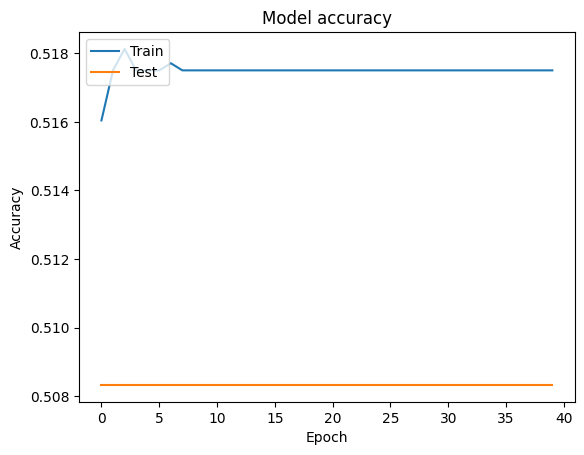

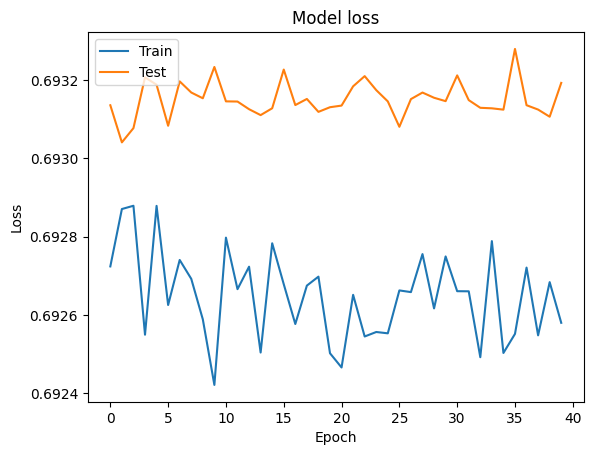

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history_cnn.history['accuracy'])
plt.plot(history_cnn.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history_cnn.history['loss'])
plt.plot(history_cnn.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Save NN models and training histories:

In [ ]:
model_dir='trained_models_low_pt/'
if not os.path.isdir(model_dir): os.system('mkdir '+model_dir)
model0.save(model_dir+'logi.h5')
model1.save(model_dir+'mlp.h5')
model_cnn.save(model_dir+'cnn.h5')
np.savez(model_dir+'training_histories.npz', [ history.history for history in [history_logi, history_mlp, history_cnn ]])


## analyze (for ttbar anc QCD discrimination and not charge)

Download the trained models from Colab, load them and analyze training/ROC curves (mkae sure you have loaded and reshaped the train/test datasets above)

In [ ]:
model_dir='trained_models_low_pt/'

history_logi, history_mlp, history_cnn = np.load(model_dir+'training_histories.npz', allow_pickle=True)['arr_0']
model0 = keras.models.load_model(model_dir+'logi.h5')
model1 = keras.models.load_model(model_dir+'mlp.h5')
model_cnn = keras.models.load_model(model_dir+'cnn.h5')

In [ ]:
predictions0 = model0.predict(x_test)
predictions1 = model1.predict(x_test)
predictions_cnn = model_cnn.predict(x_test)

693/693 [==============================] - 3s 4ms/step


In [ ]:
history_logi.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

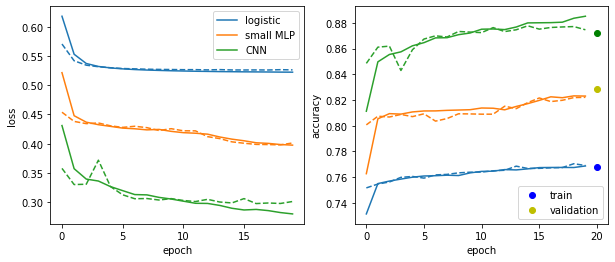

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(10,4))

nn=20
axes[1].scatter(nn, 1.*sum(np.argmax(predictions0, axis=1) == np.argmax(y_test, axis=1))/ len(y_test),c='b')
axes[1].scatter(nn, 1.*sum(np.argmax(predictions1, axis=1) == np.argmax(y_test, axis=1))/ len(y_test),c='y')
axes[1].scatter(nn, 1.*sum(np.argmax(predictions_cnn, axis=1) == np.argmax(y_test, axis=1))/ len(y_test),c='g')
for i, history in enumerate([history_logi, history_mlp, history_cnn]):
    axes[1].plot(history['accuracy'][:nn], c=plt.get_cmap("tab10")(i), label='train')
    axes[1].plot(history['val_accuracy'][:nn], c=plt.get_cmap("tab10")(i), ls ='--', label='validation')
    axes[0].plot(history['loss'][:nn], c=plt.get_cmap("tab10")(i), label=['logistic','small MLP', 'CNN', 'CNN v2'][i])
    axes[0].plot(history['val_loss'][:nn], c=plt.get_cmap("tab10")(i), ls='--')
for iax in range(2):
    axes[iax].set(xlabel='epoch', ylabel=['loss','accuracy'][iax])
axes[0].legend()
axes[1].legend(['train','validation']);
fig.savefig('training_history.png')

In [ ]:
from sklearn.metrics import roc_curve
fpr0, tpr0, thresholds = roc_curve(y_test.ravel(), predictions0.ravel())
fpr1, tpr1, thresholds = roc_curve(y_test.ravel(), predictions1.ravel())
fpr_cnn, tpr_cnn, thresholds = roc_curve(y_test.ravel(), predictions_cnn.ravel())

from sklearn.metrics import auc
auc0 = auc(fpr0, tpr0)
auc1 = auc(fpr1, tpr1)
auc2 = auc(fpr_cnn, tpr_cnn)

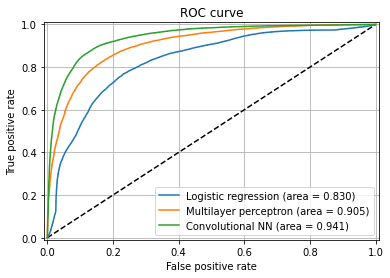

In [ ]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr0, tpr0, label='Logistic regression (area = {:.3f})'.format(auc0))
plt.plot(fpr1, tpr1, label='Multilayer perceptron (area = {:.3f})'.format(auc1))
plt.plot(fpr_cnn, tpr_cnn, label='Convolutional NN (area = {:.3f})'.format(auc2))
plt.gca().set(xlabel='False positive rate', ylabel='True positive rate', title='ROC curve', xlim=(-0.01,1.01), ylim=(-0.01,1.01))
plt.grid(True, which="both")
plt.legend(loc='lower right');
plt.savefig('ROC_curve.png')

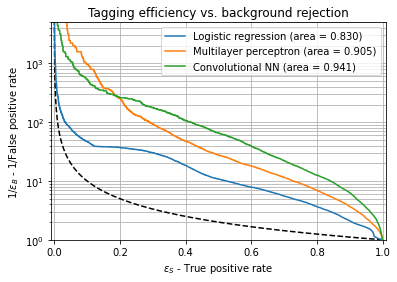

In [ ]:
np.seterr(divide='ignore', invalid='ignore') # disable warning for 1/0 divisions
plt.plot(thresholds, 1/thresholds, 'k--')
plt.plot(tpr0, 1/fpr0, label='Logistic regression (area = {:.3f})'.format(auc0))
plt.plot(tpr1, 1/fpr1, label='Multilayer perceptron (area = {:.3f})'.format(auc1))
plt.plot(tpr_cnn, 1/fpr_cnn, label='Convolutional NN (area = {:.3f})'.format(auc2))
plt.gca().set(ylabel='1/$\epsilon_B$ - 1/False positive rate', xlabel='$\epsilon_S$ - True positive rate', title='Tagging efficiency vs. background rejection', xlim=(-0.01,1.01), ylim=(1,5*10**3), yscale='log')
plt.grid(True, which="both")
plt.legend(loc='upper right');
plt.savefig('ROC_curve_bg_rej.png')

Check most certain and most uncertain NN predictions. Also check when the NN is most certain of its failed predictions

In [ ]:
predictions_cnn.argmax(axis=0)

array([  832, 12992])

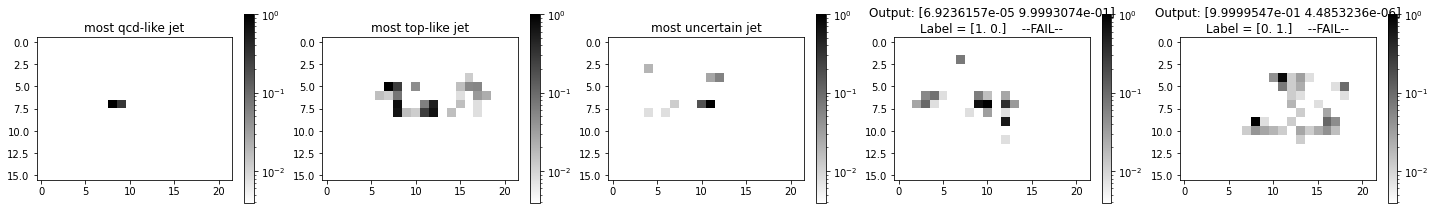

In [ ]:
logscale = True
logscale = dict(norm=mpl.colors.LogNorm()) if logscale else {}

fig, axes = plt.subplots(1,5,figsize=(20,3))
for i in range(2):
    im = axes[i].imshow(x_test[predictions_cnn.argmax(axis=0)[i],:,:,0], cmap=cmap, **logscale)
    plt.colorbar(im, ax=axes[i])
    axes[i].set(title='most {}-like jet'.format(['qcd','top'][i]))
  
axes[2].imshow(x_test[abs(predictions_cnn-0.5).argmin(axis=0)[0],:,:,0], cmap=cmap, **logscale)
plt.colorbar(im, ax=axes[2])
axes[2].set(title='most uncertain jet');

for iax, i in enumerate((predictions_cnn - y_test).argmin(axis=0)):
    im = axes[iax+3].imshow(x_test[i,:,:,0], cmap=cmap, **logscale)
    plt.colorbar(im, ax=axes[iax+3])
    axes[iax+3].set_title('Output: {}\nLabel = {}    --FAIL--'.format(predictions_cnn[i], y_test[i]))

fig.tight_layout()
fig.savefig('cnn_jet_sample.png', dpi=150)

What does the model think of an empty image?

In [ ]:
empty = np.zeros(x_test[0].shape)
[model.predict(np.array([empty])) for model in [model0, model1, model_cnn]]

[array([[0.7229311 , 0.27706897]], dtype=float32),
 array([[0.6891926 , 0.31080747]], dtype=float32),
 array([[0.9867889, 0.013211 ]], dtype=float32)]

Not great! Looks a lot like a QCD jet! Because the only difference from a sharp QCD jet is in one or a few pixels! Bad CNN! 

In real world applications, one would need to make sure they are passing images with at least one hot pixel. For example, see the image brightness:

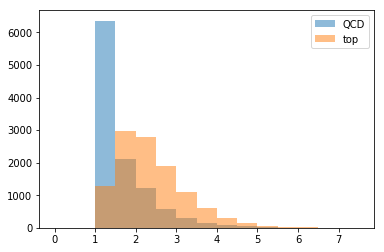

In [ ]:
plt.hist(map(np.sum, [ x for x,y in zip(x_test, y_test)[:] if np.argmax(y)==0] ), bins=np.arange(0,8,0.5), alpha=0.5, label='QCD')
plt.hist(map(np.sum, [ x for x,y in zip(x_test, y_test)[:] if np.argmax(y)==1] ), bins=np.arange(0,8,0.5), alpha=0.5, label='top')
plt.legend();